## Notebook Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip -q install --upgrade langgraph transformers peft accelerate bitsandbytes "scikit-learn==1.6.1" joblib "pandas==2.2.2" langchain-core langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.3/157.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 138.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 35.1 MB/s eta 0:00:00


In [ ]:
import json
import os
import uuid
import time
import traceback
from datetime import datetime
from typing import Optional, Dict, Any
from contextlib import contextmanager

LOG_PATH = "/content/drive/MyDrive/Colab Notebooks/Capstone_II/Final_Project/trace_log.jsonl" # adjust path
ERROR_LOG_PATH = "/content/drive/MyDrive/Colab Notebooks/Capstone_II/Final_Project/error_log.jsonl" # adjust path

# Global execution context for traceability
_execution_context = {
    "execution_id": None,
    "visit_id": None,
    "start_time": None,
}

def init_execution_context(visit_id: int):
    """Initialize execution context for a new workflow run."""
    _execution_context["execution_id"] = str(uuid.uuid4())
    _execution_context["visit_id"] = visit_id
    _execution_context["start_time"] = time.time()
    return _execution_context["execution_id"]

def get_execution_id() -> Optional[str]:
    """Get current execution ID for traceability."""
    return _execution_context.get("execution_id")

def _make_json_safe(obj):
    """
    Recursively convert objects into JSON-serializable forms.

    Rules:
    - dict     → clean keys and values
    - list/tuple → clean each element
    - basic types (int, float, str, bool, None) → keep as-is
    - anything else (custom classes like VitalSigns) → convert to str(obj)
    """
    # Basic scalar types that JSON can handle directly
    if isinstance(obj, (int, float, str, bool)) or obj is None:
        return obj

    # dict: clean each key/value
    if isinstance(obj, dict):
        return {str(k): _make_json_safe(v) for k, v in obj.items()}

    # list or tuple: clean each element
    if isinstance(obj, (list, tuple)):
        return [_make_json_safe(v) for v in obj]

    # Fallback: custom object, dataclass, pydantic model, etc.
    # We serialize it via its string representation.
    return str(obj)


def log_event(step: str, input_state: dict, output_state: dict, meta: dict = None,
              execution_id: Optional[str] = None, duration_ms: Optional[float] = None,
              error: Optional[str] = None):
    """
    Enhanced logging utility with execution tracking and performance metrics.

    Args:
        step: Name of the step/node
        input_state: Input state dictionary
        output_state: Output state dictionary
        meta: Additional metadata
        execution_id: Unique execution ID for traceability
        duration_ms: Execution duration in milliseconds
        error: Error message if any
    """
    execution_id = execution_id or get_execution_id()

    record = {
        "timestamp": datetime.now().isoformat(),
        "execution_id": execution_id,
        "step": step,
        "input_state": _make_json_safe(input_state),
        "output_state": _make_json_safe(output_state),
        "meta": _make_json_safe(meta or {}),
    }

    # Add performance metrics
    if duration_ms is not None:
        record["duration_ms"] = duration_ms
        record["meta"]["performance"] = {"duration_ms": duration_ms}

    # Add error information if present
    if error:
        record["error"] = error
        record["meta"]["error"] = error

    # Append one line per event
    try:
        with open(LOG_PATH, "a") as f:
            f.write(json.dumps(record) + "\n")
    except Exception as e:
        print(f"[WARNING] Failed to write to log file: {e}")

    # Optional console debug
    log_msg = f"[LOG] execution_id={execution_id} step={step}"
    if duration_ms is not None:
        log_msg += f" duration={duration_ms:.2f}ms"
    if error:
        log_msg += f" ERROR={error[:100]}"
    print(log_msg)


def log_error(step: str, error: Exception, state: dict = None, execution_id: Optional[str] = None):
    """
    Log errors with full context for debugging.

    Args:
        step: Name of the step where error occurred
        error: Exception object
        state: State at time of error
        execution_id: Unique execution ID
    """
    execution_id = execution_id or get_execution_id()

    error_record = {
        "timestamp": datetime.now().isoformat(),
        "execution_id": execution_id,
        "step": step,
        "error_type": type(error).__name__,
        "error_message": str(error),
        "traceback": traceback.format_exc(),
        "state": _make_json_safe(state or {}),
    }

    try:
        with open(ERROR_LOG_PATH, "a") as f:
            f.write(json.dumps(error_record) + "\n")
    except Exception as e:
        print(f"[WARNING] Failed to write to error log file: {e}")

    print(f"[ERROR] execution_id={execution_id} step={step} error={type(error).__name__}: {str(error)}")


@contextmanager
def track_performance(step_name: str):
    """Context manager to track execution time of a step."""
    start_time = time.time()
    try:
        yield
    finally:
        duration_ms = (time.time() - start_time) * 1000
        print(f"[PERF] {step_name} took {duration_ms:.2f}ms")

In [ ]:
import copy
from functools import wraps

def make_logged_node(fn, name: str, max_retries: int = 0, retry_delay: float = 0.1):
    """
    Enhanced node wrapper with:
    - Comprehensive logging with execution IDs
    - Performance tracking
    - Error handling with graceful degradation
    - Retry logic for transient failures
    - State validation

    Args:
        fn: Node function to wrap
        name: Name of the node for logging
        max_retries: Maximum number of retries for transient failures (0 = no retries)
        retry_delay: Delay between retries in seconds
    """
    def _to_serializable_dict(obj):
        """Recursively converts Pydantic BaseModel instances to dictionaries within a dict/list."""
        if isinstance(obj, BaseModel):
            return obj.model_dump()
        elif isinstance(obj, dict):
            return {k: _to_serializable_dict(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [_to_serializable_dict(elem) for elem in obj]
        return obj

    def _validate_state(state: dict, required_keys: list) -> tuple[bool, Optional[str]]:
        """Validate that required keys exist in state."""
        missing = [key for key in required_keys if key not in state or state[key] is None]
        if missing:
            return False, f"Missing required state keys: {missing}"
        return True, None

    @wraps(fn)
    def wrapped(state):
        execution_id = get_execution_id()
        start_time = time.time()

        # Create a deep copy of the state and convert Pydantic objects for logging input
        serializable_input_state = _to_serializable_dict(copy.deepcopy(state))

        # Log input
        log_event(
            f"{name}_INPUT",
            serializable_input_state,
            {},
            execution_id=execution_id
        )

        # Retry logic for transient failures
        last_error = None
        for attempt in range(max_retries + 1):
            try:
                # Run original node
                with track_performance(f"{name}_node"):
                    out = fn(state)

                # Validate output
                if out is None:
                    out = {}  # Ensure we always return a dict

                # Calculate duration
                duration_ms = (time.time() - start_time) * 1000

                # Create a deep copy of the output and convert Pydantic objects for logging output
                serializable_current_state_for_output_log = _to_serializable_dict(copy.deepcopy(state))
                serializable_output_from_node = _to_serializable_dict(copy.deepcopy(out))

                # Log output with performance metrics
                log_event(
                    f"{name}_OUTPUT",
                    serializable_current_state_for_output_log,
                    serializable_output_from_node,
                    execution_id=execution_id,
                    duration_ms=duration_ms
                )

                return out

            except Exception as e:
                last_error = e
                duration_ms = (time.time() - start_time) * 1000

                # Log error
                log_error(name, e, state, execution_id)

                # If this is the last attempt, handle the error
                if attempt == max_retries:
                    # Log failed attempt
                    log_event(
                        f"{name}_ERROR",
                        serializable_input_state,
                        {},
                        execution_id=execution_id,
                        duration_ms=duration_ms,
                        error=f"{type(e).__name__}: {str(e)}"
                    )

                    # For critical nodes, we might want to raise
                    # For non-critical nodes, return a safe default
                    if name in ["fetch_data", "severity_gate"]:
                        # Critical nodes - re-raise
                        raise
                    else:
                        # Non-critical nodes - return safe defaults
                        print(f"[WARNING] {name} failed after {max_retries + 1} attempts, using safe defaults")
                        return _get_safe_default_output(name, state)
                else:
                    # Wait before retry
                    time.sleep(retry_delay * (attempt + 1))  # Exponential backoff
                    print(f"[RETRY] {name} attempt {attempt + 1}/{max_retries + 1}")

        # Should never reach here, but just in case
        return _get_safe_default_output(name, state)

    return wrapped


def _get_safe_default_output(node_name: str, state: dict) -> dict:
    """
    Return safe default outputs for nodes that fail.
    This allows the workflow to continue with degraded functionality.
    """
    defaults = {
        "ml_model": {"ml_score": 0.5},  # Neutral probability
        "llm_model": {"llm_score": 0.5},  # Neutral probability
        "human_input": {},  # No output needed
        "fusion": {
            "fused_prob": 0.5,
            "p_final": 0.5,
            "fusion_decision": "Error",
            "fusion_rationale": "Fusion failed, using default neutral probability."
        },
        "confidence_check": state,  # Pass through
        "human_review": {
            "fused_prob": state.get("fused_prob", state.get("p_final", 0.5)),
            "p_final": state.get("fused_prob", state.get("p_final", 0.5))
        },
        "finalize": {
            "decision": "UNKNOWN",
            "rationale": f"Workflow encountered errors. Node {node_name} failed.",
            "p_final": state.get("fused_prob", state.get("p_final", 0.5))
        }
    }
    return defaults.get(node_name, {})

In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
import json
import os
import sqlite3
import torch
from typing import TypedDict, Optional, Dict, Literal
from pydantic import BaseModel, field_validator
from math import exp
from datetime import datetime

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# DEFINE PATHS

BASE_PATH           = "/content/drive/MyDrive/Colab Notebooks/Capstone_II/Final_Project" # CHANGE THIS WHEN YOU USE THE NOTEBOOK, ENSURE THE FINAL DESTINATION IS Capstone_Organized
ML_ARTIFACT_PATH    = BASE_PATH + "/3-Model_Training/3.1-Traditional_ML/3.1.0-Traditional_ML_Artifacts"
LLM_ARTIFACT_PATH   = BASE_PATH + "/3-Model_Training/3.2-LLM_Classification/3.2.0-FineTune_OpenBioLLM"

DB_PATH             = os.path.join(BASE_PATH + "/1-Data/ED_Simulated_Database_Fixed.db")

ML_MODEL_PATH       = os.path.join(ML_ARTIFACT_PATH, "gb_model.joblib")
ML_PREPROCESSOR_PATH= os.path.join(ML_ARTIFACT_PATH, "ml_preprocessor.joblib")
ML_FEATURES_PATH    = os.path.join(ML_ARTIFACT_PATH, "ml_feature_columns.json")

LLM_MODEL_ID        = "aaditya/Llama3-OpenBioLLM-8B"
LLM_MODEL_PATH      = os.path.join(LLM_ARTIFACT_PATH, "OpenBioLLM_Final")
LLM_OFFLOAD_PATH    = os.path.join(LLM_ARTIFACT_PATH, "OpenBioLLM_Offload")
os.makedirs(LLM_OFFLOAD_PATH, exist_ok=True)

assert os.path.exists(ML_MODEL_PATH), f"ML Model not found: {ML_MODEL_PATH}"
assert os.path.exists(ML_PREPROCESSOR_PATH), f"ML Preprocessor not found: {ML_PREPROCESSOR_PATH}"
assert os.path.exists(ML_FEATURES_PATH), f"ML Features JSON not found: {ML_FEATURES_PATH}"
assert os.path.exists(LLM_MODEL_PATH), f"LLM Checkpoint not found: {LLM_MODEL_PATH}"
assert os.path.exists(DB_PATH), f"Simulation DB not found: {DB_PATH}"

print("All model artifacts and simulation DB paths are verified.")

All model artifacts and simulation DB paths are verified.


## Load Artifacts & Define Helper Functions

In [ ]:
# LOAD ML ARTIFACTS

# Define function for joblib pointer
def clean_text_for_ml(text: str) -> str:
    """
    Cleans the *already redacted* notes for TF-IDF.
    This version removes the [AGE] tags and all non-alpha characters.
    (Copied from 3.1.1-Traditional_ML_Training.ipynb)
    """
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\\[.*?\\]', ' ', text) # Remove tags like [AGE]
    text = re.sub(r'[^a-zA-Z\s]', ' ', text) # Remove special characters
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip() # Consolidate whitespace
    return text

# Load joblib files
ml_model = joblib.load(ML_MODEL_PATH)
ml_preprocessor = joblib.load(ML_PREPROCESSOR_PATH)

with open(ML_FEATURES_PATH, 'r') as f:
    ml_feature_names = json.load(f)

print(f"\nSuccessfully loaded ML model and preprocessor ({len(ml_feature_names)} features).")

/usr/lib/python3.12/pickle.py:1760: UserWarning: [20:24:53] WARNING: /workspace/src/collective/../data/../common/error_msg.h:83: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)



Successfully loaded ML model and preprocessor (143 features).


In [ ]:
from peft import AutoPeftModelForSequenceClassification

classifier_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_PATH)
if classifier_tokenizer.pad_token is None:
    classifier_tokenizer.pad_token = classifier_tokenizer.eos_token

# Use AutoPeftModelForSequenceClassification to load the fine-tuned model
llm_classifier_model = AutoPeftModelForSequenceClassification.from_pretrained(
    LLM_MODEL_PATH,
    num_labels=2,
    torch_dtype=torch.float32,
    trust_remote_code=True,
    device_map="auto", # Requires a GPU!
    offload_folder=LLM_OFFLOAD_PATH
)
llm_classifier_model.eval()

print("\nSuccessfully loaded fine-tuned OpenBioLLM model.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

pytorch_model-00004-of-00004.bin:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

pytorch_model-00001-of-00004.bin:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00004.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

pytorch_model-00003-of-00004.bin:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at aaditya/Llama3-OpenBioLLM-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Successfully loaded fine-tuned OpenBioLLM model.


In [ ]:
# LOAD LLM FUSION AGENT

# 1. Configure 4-bit quantization to save memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# 2. Load the base model with AutoModelForCausalLM
llm_fusion_model = AutoModelForCausalLM.from_pretrained(
    LLM_MODEL_ID,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map="auto",
)

# 3. Load its tokenizer
fusion_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_ID, trust_remote_code=True)
if fusion_tokenizer.pad_token is None:
    fusion_tokenizer.pad_token = fusion_tokenizer.eos_token

print("\nSuccessfully loaded base OpenBioLLM *Fusion Agent* model.")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/449 [00:00<?, ?B/s]


Successfully loaded base OpenBioLLM *Fusion Agent* model.


In [ ]:
# LOAD HELPER FUNCTIONS

# --- Helper for LLM Prediction ---
def format_for_llm_classifier(patient_data: dict) -> str:
    """Formats the raw DB row for the CLASSIFICATION model."""
    return (
        f"age range: {patient_data.get('age_bucket')} / "
        f"sex: {patient_data.get('sex')} / "
        f"heart rate: {patient_data.get('heart_rate')} / "
        f"systolic blood pressure: {patient_data.get('bp_systolic')} / "
        f"diastolic blood pressure: {patient_data.get('bp_diastolic')} / "
        f"respiratory rate: {patient_data.get('resp_rate')} / "
        f"temperature in Celsius: {patient_data.get('temperature_C')} / "
        f"oxygen saturation: {patient_data.get('oxygen_saturation')} / "
        f"ESI: {int(patient_data.get('ESI', 0))} / "
        f"recent admissions (in 30 days): {int(patient_data.get('recent_admissions_30d', 0))} / "
        f"{patient_data.get('triage_notes_redacted', '')}"
    )

def llm_predict_proba(text: str) -> float:
    """Runs the formatted text through the CLASSIFIER and returns P(Admit)."""
    device = llm_classifier_model.device
    inputs = classifier_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = llm_classifier_model(**inputs).logits
        probs = torch.softmax(logits, dim=-1)[0]
        return float(probs[1].cpu().numpy())


# --- Helper for ML Prediction ---
def ml_predict_proba(patient_data: dict) -> float:
    """Runs the raw data through the ML preprocessor and model."""
    input_df = pd.DataFrame([patient_data])
    transformed_data = ml_preprocessor.transform(input_df)
    input_transformed_df = pd.DataFrame(transformed_data.toarray(), columns=ml_feature_names)
    prob_admit = ml_model.predict_proba(input_transformed_df)[0][1]
    return float(prob_admit)

print("Model helper functions defined.")

Model helper functions defined.


In [ ]:
def run_fusion_agent(ml_prob: float, llm_prob: float, human_note: str) -> dict:
    """
    Uses the generative LLM to synthesize inputs and make a
    final decision with rationale.
    """

    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert ER triage physician. Your job is to synthesize three signals to make a final, clinically sound admission decision.

You are given three inputs:
1) p_ml:  probability of admission from a traditional ML model (strong on structured vitals).
2) p_llm: probability of admission from an LLM classifier (strong on clinical text).
3) human_note: short free-text note from a nurse or physician providing real-time context.

Your task:
- Interpret all three signals.
- Resolve disagreements between the signals.
- Produce ONE final admission decision.
- Provide ONE rationale explaining exactly WHY you chose "Admit" or "Discharge".
  * Your rationale MUST explicitly reference p_ml, p_llm, and human_note.
  * It MUST give a clear clinical justification (e.g., high risk → admit, stable symptoms → discharge).

Output STRICTLY as a single valid JSON object with EXACTLY two keys:
{{
  "decision": "Admit" | "Discharge",
  "rationale": "string (2–4 sentences explaining the reason for your decision based on p_ml, p_llm, and human_note)"
}}

Do NOT output anything else.
Do NOT add comments or markdown.
Return ONLY the JSON object.
<|eot_id|><|start_header_id|>user<|end_header_id|>
Please make a final decision based on this information:
- p_ml (ML model): {ml_prob:.2f}
- p_llm (LLM classifier): {llm_prob:.2f}
- human_note: "{human_note}"

Return ONLY the JSON object described above:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

    device = llm_fusion_model.device
    inputs = fusion_tokenizer(prompt, return_tensors="pt").to(device)

    # Generate the response
    with torch.no_grad():
        outputs = llm_fusion_model.generate(
            **inputs,
            max_new_tokens=150,
            eos_token_id=fusion_tokenizer.eos_token_id
        )

    # Decode and clean the output
    response_text = fusion_tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)

    # Extract the JSON part
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    if json_match:
        try:
            return json.loads(json_match.group(0))
        except json.JSONDecodeError:
            return {"decision": "Error", "rationale": "Failed to parse LLM JSON response."}
    else:
        return {"decision": "Error", "rationale": "No JSON object found in LLM response."}

print("Fusion helper functions defined.")

Fusion helper functions defined.


### Define Graph State

In [ ]:
class VitalSigns(BaseModel):
    """Pydantic model for validating vital signs."""
    sex: Optional[str] = None
    age_bucket: Optional[str] = None
    heart_rate: Optional[float] = None
    resp_rate: Optional[float] = None
    bp_systolic: Optional[float] = None
    bp_diastolic: Optional[float] = None
    oxygen_saturation: Optional[float] = None
    temperature_C: Optional[float] = None
    ESI: Optional[int] = None
    mental_status: Optional[str] = None
    recent_admissions_30d: Optional[int] = None


class ERState(TypedDict, total=False):
    """Defines the state of our graph with optional fields for robustness."""
    visit_id: int
    human_prompt: str
    patient_data: Dict
    vitals_validated: VitalSigns
    triage_text: str
    ml_score: Optional[float]
    llm_score: Optional[float]
    severe: Optional[bool]
    p_final: Optional[float]
    fused_prob: Optional[float]
    decision: Optional[str]
    final_decision: Optional[str]
    confidence: Optional[float]
    rationale: Optional[str]
    fusion_decision: Optional[str]
    fusion_rationale: Optional[str]
    human_override: Optional[float]
    execution_id: Optional[str]  # For traceability
    error_log: Optional[list]  # Track errors during execution

print("LangGraph state defined with enhanced optional fields for robustness.")


def validate_initial_state(state: dict) -> tuple[bool, Optional[str]]:
    """
    Validate initial state before workflow execution.

    Returns:
        (is_valid, error_message)
    """
    required = ["visit_id"]
    missing = [key for key in required if key not in state]
    if missing:
        return False, f"Missing required initial state keys: {missing}"

    if not isinstance(state.get("visit_id"), int) or state["visit_id"] <= 0:
        return False, f"Invalid visit_id: {state.get('visit_id')}"

    return True, None


def validate_state_transition(state: dict, node_name: str) -> tuple[bool, Optional[str]]:
    """
    Validate state before node execution based on node requirements.

    Returns:
        (is_valid, error_message)
    """
    node_requirements = {
        "fetch_data": ["visit_id"],
        "severity_gate": ["vitals_validated"],
        "ml_model": ["patient_data"],
        "llm_model": ["patient_data"],
        "human_input": ["human_prompt"],
        "fusion": ["ml_score", "llm_score"],
        "confidence_check": ["ml_score", "llm_score", "fused_prob"],
        "human_review": ["fused_prob"],
        "finalize": ["fused_prob"],
    }

    required = node_requirements.get(node_name, [])
    missing = [key for key in required if key not in state or state[key] is None]
    if missing:
        return False, f"Node {node_name} missing required state keys: {missing}"

    return True, None

LangGraph state defined with enhanced optional fields for robustness.


In [ ]:
# --- Node 1: Fetch Data from DB ---
def fetch_data_node(state: ERState):
    """
    Fetch Data Node
    ---------------
    Takes a visit_id, connects to the DB, and fetches the patient's
    de-identified data from Visit_Details, Triage_Notes, and ESI.

    According to the diagram flow:
    - START → fetch_data (solid arrow)
    - fetch_data → severity_gate (solid arrow)

    Enhanced with:
    - Input validation
    - Better error messages
    - Execution ID tracking
    """
    visit_id = state.get('visit_id')
    execution_id = get_execution_id()

    # Validate input
    if not visit_id or not isinstance(visit_id, int) or visit_id <= 0:
        raise ValueError(f"Invalid visit_id: {visit_id}")

    print(f"--- 1. Fetching data for visit_id: {visit_id} (execution_id: {execution_id}) ---")

    # Initialize execution context if not already set
    if execution_id is None:
        init_execution_context(visit_id)
        execution_id = get_execution_id()

    # Update state with execution ID for traceability
    state_update = {"execution_id": execution_id}

    conn = None
    try:
        # Validate DB path exists
        if not os.path.exists(DB_PATH):
            raise FileNotFoundError(f"Database file not found: {DB_PATH}")

        conn = sqlite3.connect(DB_PATH, timeout=10.0)  # Add timeout
        conn.row_factory = sqlite3.Row

        query = """
        SELECT
            v.visit_id, v.patient_id, v.sex, v.age_bucket,
            v.heart_rate, v.bp_systolic, v.bp_diastolic, v.resp_rate,
            v.temperature_C, v.oxygen_saturation, v.recent_admissions_30d,
            v.admitted,
            t.triage_notes_redacted,
            e.ESI
        FROM Visit_Details v
        LEFT JOIN Triage_Notes t ON v.visit_id = t.visit_id AND v.patient_id = t.patient_id
        LEFT JOIN ESI e ON v.visit_id = e.visit_id AND v.patient_id = e.patient_id
        WHERE v.visit_id = ?
        """

        cursor = conn.cursor()
        cursor.execute(query, (visit_id,))
        row = cursor.fetchone()

    except sqlite3.Error as e:
        error_msg = f"Database error for visit_id {visit_id}: {str(e)}"
        log_error("fetch_data", e, state, execution_id)
        raise RuntimeError(error_msg) from e
    except Exception as e:
        error_msg = f"Unexpected error fetching data for visit_id {visit_id}: {str(e)}"
        log_error("fetch_data", e, state, execution_id)
        raise
    finally:
        if conn:
            try:
                conn.close()
            except Exception:
                pass  # Ignore errors during cleanup

    if row is None:
        error_msg = f"No data found for visit_id: {visit_id} in {DB_PATH}"
        raise ValueError(error_msg)

    patient_data = dict(row)

    # Validate that we have essential data
    if not patient_data.get('visit_id'):
        raise ValueError(f"Invalid patient data returned for visit_id: {visit_id}")

    # Validate vitals with error handling
    try:
        vitals_validated = VitalSigns(**patient_data)
    except Exception as e:
        log_error("fetch_data_vitals_validation", e, {"patient_data": patient_data}, execution_id)
        # Try to create with minimal required fields
        vitals_validated = VitalSigns(
            sex=patient_data.get('sex'),
            age_bucket=patient_data.get('age_bucket'),
            heart_rate=patient_data.get('heart_rate'),
            resp_rate=patient_data.get('resp_rate'),
            bp_systolic=patient_data.get('bp_systolic'),
            bp_diastolic=patient_data.get('bp_diastolic'),
            oxygen_saturation=patient_data.get('oxygen_saturation'),
            temperature_C=patient_data.get('temperature_C'),
            ESI=patient_data.get('ESI'),
            recent_admissions_30d=patient_data.get('recent_admissions_30d')
        )

    state_update.update({
        "patient_data": patient_data,
        "vitals_validated": vitals_validated,
        "triage_text": patient_data.get('triage_notes_redacted', '')
    })

    return state_update

# --- Node 2: Severity Gate ---
def severity_gate_node(state: ERState):
    """
    Severity Gate Node
    ------------------
    Checks for any critical vital signs that would require immediate admission.

    According to the diagram flow:
    - fetch_data → severity_gate (solid arrow)
    - severity_gate has two conditional paths:
      1. Early exit (dotted arrow labeled "end") → END
      2. Continue (dotted arrow) → run_models
    """
    print("--- 2. Checking severity gate ---")
    v = state["vitals_validated"]

    if (v.oxygen_saturation is not None and v.oxygen_saturation < 88) or \
       (v.bp_systolic is not None and v.bp_systolic < 80) or \
       (v.resp_rate is not None and (v.resp_rate > 35 or v.resp_rate < 8)):
        print(" -> CRITICAL: Patient is severe. Bypassing models.")
        return {
            "severe": True,
            "decision": "Admit",
            "p_final": 1.0,
            "rationale": "Critical vital signs detected. Bypassed ML/LLM."
        }

    print(" -> OK: Patient is not severe. Proceeding to models.")
    return {"severe": False}

In [ ]:
# --- Node 3a: ML Model ---
def ml_model_node(state: ERState):
    """
    ML Model Node
    -------------
    Runs the patient data through the retrained ML pipeline.

    According to the diagram flow:
    - run_models → ml_model (solid arrow, parallel execution)
    - ml_model → fusion (solid arrow, converges with other models)

    Enhanced with:
    - Input validation
    - Error handling with fallback
    - Score validation (0-1 range)
    """
    print("--- 3a. Running ML Model ---")

    # Validate input
    patient_data = state.get('patient_data')
    if not patient_data:
        raise ValueError("Missing patient_data for ML model")

    try:
        score = ml_predict_proba(patient_data)

        # Validate score is in valid range
        if not isinstance(score, (int, float)) or score < 0 or score > 1:
            print(f"[WARNING] ML model returned invalid score: {score}, clamping to [0, 1]")
            score = max(0.0, min(1.0, float(score)))

        print(f" -> ML Score (P_Admit): {score:.4f}")
        return {"ml_score": float(score)}

    except Exception as e:
        log_error("ml_model", e, state, get_execution_id())
        # Return neutral score on error
        print(f"[WARNING] ML model failed, using neutral score: {e}")
        return {"ml_score": 0.5}

# --- Node 3b: LLM Model ---
def llm_model_node(state: ERState):
    """
    LLM Model Node
    --------------
    Runs the patient data through the retrained LLM pipeline.

    According to the diagram flow:
    - run_models → llm_model (solid arrow, parallel execution)
    - llm_model → fusion (solid arrow, converges with other models)

    Enhanced with:
    - Input validation
    - Error handling with fallback
    - Score validation (0-1 range)
    """
    print("--- 3b. Running LLM Classifier ---")

    # Validate input
    patient_data = state.get('patient_data')
    if not patient_data:
        raise ValueError("Missing patient_data for LLM model")

    try:
        formatted_text = format_for_llm_classifier(patient_data)

        # Validate formatted text is not empty
        if not formatted_text or not formatted_text.strip():
            print("[WARNING] Empty formatted text for LLM, using default")
            formatted_text = "No patient data available."

        score = llm_predict_proba(formatted_text)

        # Validate score is in valid range
        if not isinstance(score, (int, float)) or score < 0 or score > 1:
            print(f"[WARNING] LLM model returned invalid score: {score}, clamping to [0, 1]")
            score = max(0.0, min(1.0, float(score)))

        print(f" -> LLM Classifier Score (P_Admit): {score:.4f}")
        return {"llm_score": float(score)}

    except Exception as e:
        log_error("llm_model", e, state, get_execution_id())
        # Return neutral score on error
        print(f"[WARNING] LLM model failed, using neutral score: {e}")
        return {"llm_score": 0.5}

# --- Node 3c: Human Input ---
def human_input_node(state: ERState):
    """
    Human Input Node
    ---------------
    This node acknowledges and processes the human prompt/note.

    According to the diagram flow:
    - run_models → human_input (solid arrow, parallel execution)
    - human_input → fusion (solid arrow, converges with other models)
    """
    print("--- 3c. Acknowledging Human Input ---")
    print(f" -> Human Note: '{state['human_prompt']}'")
    return {}

In [ ]:
# --- Node 4: Fusion ---
def fusion_node(state: ERState):
    """
    Fusion Node
    -----------
    Fuses the outputs from human_input, llm_model, and ml_model.

    According to the diagram flow:
    - human_input, llm_model, ml_model → fusion (solid arrows, all converge)
    - fusion → confidence_check (solid arrow)

    Calls the generative fusion agent (run_fusion_agent) to produce:
      - fusion_decision    : "Admit" / "Discharge" / "Error"
      - fusion_rationale   : textual explanation (2–4 sentences)

    Also computes a numeric fused probability:
      fused_prob = 0.7 * ml_prob + 0.3 * llm_prob

    Returns a partial state update with:
      - fused_prob
      - p_final            (alias for fused_prob)
      - fusion_decision
      - fusion_rationale
    """

    print("--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---")

    # Validate and extract inputs with defaults
    ml_prob = state.get("ml_score")
    llm_prob = state.get("llm_score")
    human_note = (state.get("human_prompt") or "").strip()

    # Validate scores exist and are valid
    if ml_prob is None:
        print("[WARNING] ml_score missing, using default 0.5")
        ml_prob = 0.5
    if llm_prob is None:
        print("[WARNING] llm_score missing, using default 0.5")
        llm_prob = 0.5

    # Ensure scores are in valid range
    ml_prob = max(0.0, min(1.0, float(ml_prob)))
    llm_prob = max(0.0, min(1.0, float(llm_prob)))

    execution_id = get_execution_id()

    # 1) Call fusion agent with error handling
    fusion_output = None
    fusion_error = None
    try:
        fusion_output = run_fusion_agent(
            ml_prob=ml_prob,
            llm_prob=llm_prob,
            human_note=human_note,
        )

        # Validate fusion output
        if not isinstance(fusion_output, dict):
            raise ValueError("Fusion agent returned non-dict output")

    except Exception as e:
        fusion_error = str(e)
        log_error("fusion_agent", e, state, execution_id)
        print(f" -> Fusion agent raised an exception: {e}")
        fusion_output = {
            "decision": "Error",
            "rationale": f"Exception during fusion agent call: {e}. Using weighted average.",
        }

    fusion_decision = fusion_output.get("decision", "Error") if fusion_output else "Error"
    fusion_rationale = fusion_output.get(
        "rationale",
        "No rationale returned by fusion agent. Using weighted average of ML and LLM scores."
    ) if fusion_output else "Fusion agent failed. Using weighted average."

    # 2) Numeric fused probability (always compute as fallback)
    fused_prob = 0.7 * ml_prob + 0.3 * llm_prob

    # If fusion agent failed, use weighted average as decision
    if fusion_error or fusion_decision == "Error":
        if fused_prob >= 0.5:
            fusion_decision = "Admit"
        else:
            fusion_decision = "Discharge"
        fusion_rationale = f"Fusion agent unavailable. Using weighted average (0.7*ML + 0.3*LLM) = {fused_prob:.3f}. Decision: {fusion_decision}."

    print(
        f" -> Final P(Admit) Score (numeric): {fused_prob:.4f} | "
        f"Fusion Agent Decision: {fusion_decision}"
    )
    print(f" -> Fusion Agent Rationale (inside fusion_node): {fusion_rationale}")

    # 3) VERY IMPORTANT: return all fields you want to keep in the state
    return {
        "fused_prob": float(fused_prob),
        "p_final": float(fused_prob),
        "fusion_decision": fusion_decision,
        "fusion_rationale": fusion_rationale,
    }



# --- Conditional Edge: Severity Gate ---
def conditional_severity_gate(state: ERState):
    """
    Conditional Severity Gate Routing
    ----------------------------------
    Routes the workflow based on severity assessment:
    - If severe (critical vitals) → "end" (early exit to END)
    - If not severe → "run_models" (proceed to parallel model execution)

    This matches the diagram flow where severity_gate has two paths:
    1. Early exit path (dotted arrow labeled "end") → END
    2. Continue path (dotted arrow) → run_models
    """
    if state.get("severe", False):
        print("[Routing] Severe case detected → early exit to END")
        return "end"  # Go straight to the end (early exit path)
    else:
        print("[Routing] Non-severe case → proceeding to run_models")
        return "run_models"  # Proceed to parallel branches

print("Fusion & Logic nodes defined.")

Fusion & Logic nodes defined.


In [ ]:
def confidence_check_node(state: ERState):
    """
    Confidence Check Node
    ---------------------
    This node is executed after the fusion step.

    According to the diagram flow:
    - fusion → confidence_check (solid arrow)
    - confidence_check has two conditional paths:
      1. high_confidence (dotted arrow) → finalize
      2. low_confidence (dotted arrow) → human_review

    Purpose:
    - Validate that ML and LLM scores exist in the state.
    - Print debugging information for verification.
    - Pass-through node (no state modification).

    NOTE:
    The actual routing decision (high vs. low confidence)
    is performed by `conditional_confidence_routing`.
    """
    ml = state.get("ml_score")
    llm = state.get("llm_score")
    fused_prob = state.get("fused_prob", state.get("p_final"))
    print("--- 5. Confidence Check Node ---")
    print(f"[ConfidenceCheck] ml_score={ml:.4f}, llm_score={llm:.4f}, fused_prob={fused_prob:.4f}")
    return state

def human_review_node(state: ERState):
    """
    Human Review Node (HITL - Human In The Loop)
    ---------------------------------------------
    This node is executed when confidence_check routes to low_confidence.

    According to the diagram flow:
    - confidence_check → low_confidence (dotted arrow) → human_review
    - human_review → finalize (solid arrow)

    This node provides human oversight for low-confidence cases.

    Workflow:
    1. On first pass, LangGraph stops *before* this node
       if interrupt_before=["human_review"] is set.
    2. You manually inspect the state via get_state().
    3. You insert state["human_override"] manually.
    4. The graph is resumed → this node executes.

    Behavior:
    - If human_override exists → override fused_prob.
    - If not → use the original fused_prob.

    This ensures fully traceable HITL correction.
    """
    print("--- 6. Human Review Node (HITL) ---")
    override = state.get("human_override", None)

    if override is not None:
        output = {"fused_prob": float(override), "p_final": float(override)}
        log_event("human_review_override", dict(state), output)
        print(f"[HITL] Human override applied → fused_prob={override:.4f}")
        return output

    # No override → retain original fused_prob
    fused_prob = state.get("fused_prob", state.get("p_final"))
    output = {"fused_prob": float(fused_prob), "p_final": float(fused_prob)}
    log_event("human_review_no_override", dict(state), output)
    print(f"[HITL] No override provided → using original fused_prob={fused_prob:.4f}")
    return output



# 2d. finalize node
def finalize_node(state: ERState):
    """
    Finalize Node
    -------------
    This node produces the final admission decision and rationale.

    According to the diagram flow:
    - finalize can be reached from two paths:
      1. confidence_check → high_confidence (dotted arrow) → finalize
      2. confidence_check → low_confidence → human_review → finalize (solid arrow)
    - finalize → END (solid arrow)

    Decision rule:
      - ADMIT     if fused_prob >= 0.50
      - DISCHARGE if fused_prob <  0.50
      - UNKNOWN   if fused_prob is missing

    It writes the following fields into the state:
      - final_decision : canonical final decision
      - rationale      : canonical final rationale
      - decision       : backward-compatible alias
      - p_final        : backward-compatible alias for fused_prob

    IMPORTANT:
      - We start from the existing state (`dict(state)`) so that
        previous fields like `fusion_rationale` are preserved.
    """

    print("--- 7. Finalize Node ---")

    # Prefer fused_prob, but fall back to p_final if needed
    fused = state.get("fused_prob", state.get("p_final", None))

    if fused is None:
        decision = "UNKNOWN"
        rationale = (
            "Missing fused_prob; unable to generate a final decision. "
            "Check fusion or human review steps."
        )
    else:
        THRESH = 0.5
        if fused >= THRESH:
            decision = "ADMIT"
            rationale = (
                f"Fused probability {fused:.2f} ≥ threshold {THRESH:.2f}; "
                "patient should be admitted."
            )
        else:
            decision = "DISCHARGE"
            rationale = (
                f"Fused probability {fused:.2f} < threshold {THRESH:.2f}; "
                "patient may be safely discharged."
            )

    # Merge decision fields back into the *existing* state
    new_state = dict(state)
    new_state["final_decision"] = decision
    new_state["rationale"] = rationale

    # Backward-compatible aliases
    new_state["decision"] = decision
    new_state["p_final"] = fused

    log_event("finalize_node", dict(state), new_state)
    print(f"[Finalize] Decision={decision}, Rationale={rationale}")

    return new_state


# 2e. confidence routing function（decide high / low confidence）
def conditional_confidence_routing(state: ERState):
    """
    Conditional Confidence Routing
    ------------------------------
    This function determines whether the workflow should:
    - Auto-complete the decision (high confidence), OR
    - Trigger a Human Review (low confidence)

    According to the diagram flow:
    - confidence_check has two conditional paths:
      1. high_confidence (dotted arrow) → finalize
      2. low_confidence (dotted arrow) → human_review

    It returns one of ONLY these keys (must match add_conditional_edges):
        - "high_confidence"
        - "low_confidence"

    This ensures LangGraph can correctly route AND
    ensures the interrupt_before=["human_review"] will fire
    when low confidence is detected.

    Routing Logic:
    1. If ML or LLM score is missing → LOW CONFIDENCE (force review)
    2. Compute:
        - probability gap = |ml_score - llm_score|
        - average score   = (ml_score + llm_score) / 2
    3. High confidence if:
        - gap < 0.20  AND  avg > 0.70
    4. Otherwise → low confidence → human review
    """
    ml = state.get("ml_score")
    llm = state.get("llm_score")

    # Missing scores → force human review
    if ml is None or llm is None:
        print("[Routing] Missing ML/LLM scores → LOW confidence → human_review")
        return "low_confidence"

    prob_gap = abs(ml - llm)
    avg_prob = (ml + llm) / 2

    HIGH_CONF_GAP = 0.20
    HIGH_CONF_THRESH = 0.70

    # High confidence path (matches diagram: high_confidence → finalize)
    if prob_gap < HIGH_CONF_GAP and avg_prob > HIGH_CONF_THRESH:
        print(f"[Routing] HIGH confidence (gap={prob_gap:.2f}, avg={avg_prob:.2f}) → finalize")
        return "high_confidence"

    # Low confidence path (matches diagram: low_confidence → human_review)
    print(f"[Routing] LOW confidence (gap={prob_gap:.2f}, avg={avg_prob:.2f}) → human_review")
    return "low_confidence"


# Define a router node for parallel execution
def run_models_node(state: ERState):
    """
    Run Models Router Node
    ----------------------
    This is a router node that triggers the parallel model runs.

    According to the diagram flow:
    - severity_gate → run_models (dotted arrow, when not severe)
    - run_models fans out in parallel to:
      1. human_input (solid arrow)
      2. llm_model (solid arrow)
      3. ml_model (solid arrow)
    - All three converge into fusion (solid arrows from each)
    """
    print("--- 3. Fanning out to parallel models (human_input, llm_model, ml_model) ---")
    return {}

## Initiate the Graph

In [ ]:
# 1. Initialize the graph
workflow = StateGraph(ERState)

In [ ]:
# ============================================
# Graph Construction - Matching Diagram Flow
# ============================================
# Flow according to diagram:
# START → fetch_data → severity_gate → (end OR run_models)
#   → run_models → [human_input, llm_model, ml_model] (parallel)
#   → fusion → confidence_check → (high_confidence OR low_confidence)
#   → (high_confidence → finalize) OR (low_confidence → human_review → finalize)
#   → finalize → END

# Add all the nodes with enhanced error handling and retry logic
# Critical nodes (fetch_data, severity_gate) have no retries - failures should be explicit
# Non-critical nodes can retry transient failures

workflow.add_node("fetch_data", make_logged_node(fetch_data_node, "fetch_data", max_retries=0))
workflow.add_node("severity_gate", make_logged_node(severity_gate_node, "severity_gate", max_retries=0))
workflow.add_node("run_models", make_logged_node(run_models_node, "run_models", max_retries=0))   # router node
workflow.add_node("ml_model", make_logged_node(ml_model_node, "ml_model", max_retries=1, retry_delay=0.5))
workflow.add_node("llm_model", make_logged_node(llm_model_node, "llm_model", max_retries=1, retry_delay=0.5))
workflow.add_node("human_input", make_logged_node(human_input_node, "human_input", max_retries=0))
workflow.add_node("fusion", make_logged_node(fusion_node, "fusion", max_retries=1, retry_delay=1.0))
workflow.add_node("confidence_check", make_logged_node(confidence_check_node, "confidence_check", max_retries=0))
workflow.add_node("human_review", make_logged_node(human_review_node, "human_review", max_retries=0))
workflow.add_node("finalize", make_logged_node(finalize_node, "finalize", max_retries=0))

# ============================================
# Define the graph flow (matching diagram)
# ============================================

# START → fetch_data (entry point)
workflow.set_entry_point("fetch_data")

# fetch_data → severity_gate (solid arrow)
workflow.add_edge("fetch_data", "severity_gate")

# severity_gate → conditional routing (matches diagram: two dotted arrows)
#   - "end" (early exit) → END
#   - "run_models" (continue) → run_models
workflow.add_conditional_edges(
    "severity_gate",
    conditional_severity_gate,
    {
        "run_models": "run_models",  # Continue path (dotted arrow in diagram)
        "end": END,                   # Early exit path (dotted arrow labeled "end" in diagram)
    },
)

# run_models → parallel fan-out (matches diagram: three solid arrows)
# All three models run in parallel
workflow.add_edge("run_models", "ml_model")
workflow.add_edge("run_models", "llm_model")
workflow.add_edge("run_models", "human_input")

# Converge into fusion (matches diagram: three solid arrows converging)
# All three parallel branches must complete before fusion runs
workflow.add_edge("ml_model", "fusion")
workflow.add_edge("llm_model", "fusion")
workflow.add_edge("human_input", "fusion")

# fusion → confidence_check (solid arrow)
workflow.add_edge("fusion", "confidence_check")

# confidence_check → conditional routing (matches diagram: two dotted arrows)
#   - "high_confidence" (dotted arrow) → finalize
#   - "low_confidence" (dotted arrow) → human_review
workflow.add_conditional_edges(
    "confidence_check",
    conditional_confidence_routing,
    {
        "high_confidence": "finalize",    # High confidence path (dotted arrow in diagram)
        "low_confidence": "human_review",  # Low confidence path (dotted arrow in diagram)
    },
)

# human_review → finalize (solid arrow)
# This path is taken when confidence is low
workflow.add_edge("human_review", "finalize")

# finalize → END (solid arrow)
workflow.add_edge("finalize", END)

# ============================================
# Compile the graph
# ============================================
memory = MemorySaver()
graph = workflow.compile(
    checkpointer=memory,
    #interrupt_before=["human_review"],  # Uncomment to enable HITL interrupt
)

print("\n--- LangGraph Compiled Successfully! ---")
print("Graph flow matches the diagram:")
print("  START → fetch_data → severity_gate → (end OR run_models)")
print("    → run_models → [human_input, llm_model, ml_model] (parallel)")
print("    → fusion → confidence_check → (high_confidence OR low_confidence)")
print("    → (high_confidence → finalize) OR (low_confidence → human_review → finalize)")
print("    → finalize → END")


--- LangGraph Compiled Successfully! ---
Graph flow matches the diagram:
  START → fetch_data → severity_gate → (end OR run_models)
    → run_models → [human_input, llm_model, ml_model] (parallel)
    → fusion → confidence_check → (high_confidence OR low_confidence)
    → (high_confidence → finalize) OR (low_confidence → human_review → finalize)
    → finalize → END


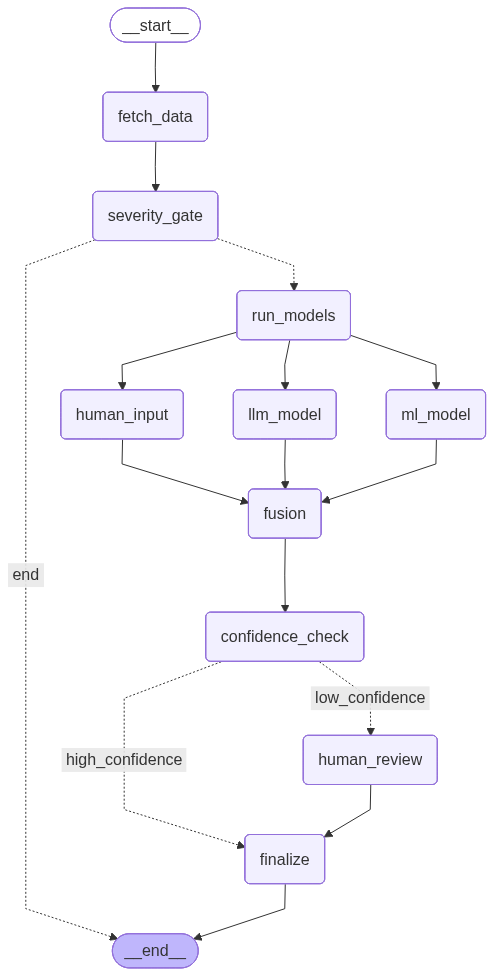

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    print("Could not draw graph. Skipping visualization.")

## Test Run the Graph

In [ ]:
## Enhanced Workflow Invocation Helper

def invoke_workflow_with_tracking(graph, inputs: dict, config: dict = None):
    """
    Enhanced workflow invocation with automatic execution tracking.

    This function:
    1. Validates initial state
    2. Initializes execution context
    3. Invokes the graph
    4. Returns results with execution metadata

    Args:
        graph: Compiled LangGraph workflow
        inputs: Input state dictionary
        config: LangGraph configuration (optional)

    Returns:
        Final state dictionary with execution metadata
    """
    # Validate initial state
    is_valid, error_msg = validate_initial_state(inputs)
    if not is_valid:
        raise ValueError(f"Invalid initial state: {error_msg}")

    # Initialize execution context
    visit_id = inputs.get('visit_id')
    execution_id = init_execution_context(visit_id)

    print(f"\n{'='*60}")
    print(f"Starting workflow execution")
    print(f"  Execution ID: {execution_id}")
    print(f"  Visit ID: {visit_id}")
    print(f"{'='*60}\n")

    try:
        # Invoke graph
        if config is None:
            config = {"configurable": {"thread_id": f"exec-{execution_id}"}}

        final_state = graph.invoke(inputs, config)

        # Add execution metadata
        execution_time = time.time() - _execution_context["start_time"]
        final_state["execution_metadata"] = {
            "execution_id": execution_id,
            "visit_id": visit_id,
            "execution_time_seconds": execution_time,
            "timestamp": datetime.now().isoformat()
        }

        print(f"\n{'='*60}")
        print(f"Workflow execution completed")
        print(f"  Execution ID: {execution_id}")
        print(f"  Total time: {execution_time:.2f}s")
        print(f"  Final decision: {final_state.get('decision', 'N/A')}")
        print(f"{'='*60}\n")

        return final_state

    except Exception as e:
        execution_time = time.time() - _execution_context["start_time"]
        log_error("workflow_invocation", e, inputs, execution_id)

        print(f"\n{'='*60}")
        print(f"Workflow execution failed")
        print(f"  Execution ID: {execution_id}")
        print(f"  Time before failure: {execution_time:.2f}s")
        print(f"  Error: {type(e).__name__}: {str(e)}")
        print(f"{'='*60}\n")

        raise

print("Enhanced workflow invocation helper defined.")


Enhanced workflow invocation helper defined.


In [ ]:
# --- Run 1: High-Risk Patient Note ---
# We'll use visit_id=1 and add a high-risk note
inputs_1 = {
    "visit_id": 1,
    "human_prompt": "Patient is 70yo, frail, and on chemotherapy."
}
config = {"configurable": {"thread_id": "sim-1"}}

print("--- Running Simulation 1 (High-Risk Note) ---")
final_state_1 = graph.invoke(inputs_1, config)

print("\n--- Final State 1 ---")
print(f"Decision: {final_state_1.get('decision')}")
print(f"P(Admit): {final_state_1.get('p_final'):.4f}")
print(f"Final Rationale: {final_state_1.get('rationale')}")
print(f"Fusion Rationale: {final_state_1.get('fusion_rationale')}")


# --- Run 2: Low-Risk Patient Note ---
# We'll use visit_id=5 (assuming this is a lower-risk patient in the DB)
inputs_2 = {
    "visit_id": 5,
    "human_prompt": "Patient looks stable, likely just needs follow-up."
}
config = {"configurable": {"thread_id": "sim-2"}}

print("\n\n--- Running Simulation 2 (Low-Risk Note) ---")
final_state_2 = graph.invoke(inputs_2, config)

print("\n--- Final State 2 ---")
print(f"Decision: {final_state_2.get('decision')}")
print(f"P(Admit): {final_state_2.get('p_final'):.4f}")
print(f"Final Rationale: {final_state_2.get('rationale')}")
print(f"Fusion Rationale: {final_state_2.get('fusion_rationale')}")

--- Running Simulation 1 (High-Risk Note) ---
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=fetch_data_INPUT
--- 1. Fetching data for visit_id: 1 (execution_id: 91a5cd44-2ca1-4640-8687-21ce1cee764c) ---
[PERF] fetch_data_node took 4.62ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=fetch_data_OUTPUT duration=8.21ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=severity_gate_INPUT
--- 2. Checking severity gate ---
 -> OK: Patient is not severe. Proceeding to models.
[PERF] severity_gate_node took 0.01ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=severity_gate_OUTPUT duration=2.20ms
[Routing] Non-severe case → proceeding to run_models
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=run_models_INPUT
--- 3. Fanning out to parallel models (human_input, llm_model, ml_model) ---
[PERF] run_models_node took 0.01ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=run_models_OUTPUT duration=2.27ms
[LOG] exec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Classifier Score (P_Admit): 0.9899
[PERF] llm_model_node took 172.64ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=llm_model_OUTPUT duration=178.27ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=fusion_INPUT
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---
 -> Final P(Admit) Score (numeric): 0.8657 | Fusion Agent Decision: Admit
 -> Fusion Agent Rationale (inside fusion_node): Given the patient's frailty, age, and current chemotherapy, the high probabilities from both the ML model and LLM classifier, along with the clinical context provided by the human_note, support the decision to admit the patient.
[PERF] fusion_node took 3191.89ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=fusion_OUTPUT duration=3205.24ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=confidence_check_INPUT
--- 5. Confidence Check Node ---
[ConfidenceCheck] ml_score=0.8125, llm_score=0.9899, fused_prob=0.865

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Classifier Score (P_Admit): 0.9807
[PERF] llm_model_node took 169.42ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=llm_model_OUTPUT duration=174.98ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=fusion_INPUT
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---
 -> Final P(Admit) Score (numeric): 0.3588 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Based on the LLM classifier's high probability of admission (0.98), and the nurse's note suggesting the patient is stable and likely needs follow-up, we decide to discharge the patient. Despite the ML model's lower probability (0.09), the clinical context provided by the human_note overrides the machine learning prediction.
[PERF] fusion_node took 4279.19ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=fusion_OUTPUT duration=4281.69ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=confidence_check_INPUT
-

Human review test (haven't adjusted good)

In [ ]:
# ============================================
# Simulation 2: Low-Risk Note (HITL demo)
# Step 1 — Run until interrupt BEFORE 'human_review'
# ============================================

inputs_2 = {
    "visit_id": 5,
    "human_prompt": "Patient looks stable, likely just needs follow-up."
}

config_2 = {"configurable": {"thread_id": "sim-2"}}

print("\n--- Running Simulation 2 (Low-Risk Note) — Phase 1 (until interrupt) ---")

# 1) Run the graph; it will stop before 'human_review'
for event in graph.stream(inputs_2, config_2):
    # Each event is a dict like {"node_name": {...partial_state_update...}}
    print(event)

# 2) After the interrupt, fetch the current state from the checkpointer
state_before_review = graph.get_state(config_2).values

print("\n--- State BEFORE Human Review (Simulation 2) ---")
print("Keys:", state_before_review.keys())

# 3) Inspect model / fusion outputs to help the human reviewer
print(f"\nML score (p_ml):      {state_before_review.get('ml_score')}")
print(f"LLM score (p_llm):    {state_before_review.get('llm_score')}")
print(f"Fused P(Admit):       {state_before_review.get('p_final')}")
print(f"Fusion Decision:      {state_before_review.get('fusion_decision')}")
print(f"Fusion Rationale:     {state_before_review.get('fusion_rationale')}")
print(f"Original Human Note:  {state_before_review.get('human_prompt')}")



--- Running Simulation 2 (Low-Risk Note) — Phase 1 (until interrupt) ---
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=fetch_data_INPUT
--- 1. Fetching data for visit_id: 5 (execution_id: 91a5cd44-2ca1-4640-8687-21ce1cee764c) ---
[PERF] fetch_data_node took 5.18ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=fetch_data_OUTPUT duration=9.04ms
{'fetch_data': {'execution_id': '91a5cd44-2ca1-4640-8687-21ce1cee764c', 'patient_data': {'visit_id': 5, 'patient_id': 'aa17128506622ee5', 'sex': 'Male', 'age_bucket': '18-34', 'heart_rate': 65.0, 'bp_systolic': 187.0, 'bp_diastolic': 77.0, 'resp_rate': 22.0, 'temperature_C': 39.9, 'oxygen_saturation': 91.0, 'recent_admissions_30d': 0, 'admitted': 0, 'triage_notes_redacted': 'the patient presents with chest pain for 2 hours, rated 7/10. Onset after eating dinner, associated with sharp stabbing pain. Denies recent travel or sick contacts. Past medical history includes COPD; Hypertension. Current medications: none repor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Classifier Score (P_Admit): 0.9807
[PERF] llm_model_node took 187.71ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=llm_model_OUTPUT duration=192.30ms
{'llm_model': {'llm_score': 0.9806503653526306}}
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=fusion_INPUT
--- 4. Fusing Inputs with LLM Agent (combining human_input, llm_model, ml_model) ---
 -> Final P(Admit) Score (numeric): 0.3588 | Fusion Agent Decision: Discharge
 -> Fusion Agent Rationale (inside fusion_node): Fusion agent unavailable. Using weighted average (0.7*ML + 0.3*LLM) = 0.359. Decision: Discharge.
[PERF] fusion_node took 2943.15ms
[LOG] execution_id=91a5cd44-2ca1-4640-8687-21ce1cee764c step=fusion_OUTPUT duration=2945.35ms
{'fusion': {'fused_prob': 0.35876570045948025, 'p_final': 0.35876570045948025, 'fusion_decision': 'Discharge', 'fusion_rationale': 'Fusion agent unavailable. Using weighted average (0.7*ML + 0.3*LLM) = 0.359. Decision: Discharge.'}}
[LOG] execution_id=91a5cd44-2ca

In [ ]:
# ============================================
# Simulation 2: Low-Risk Note (HITL demo)
# Step 2 — Apply human_override and resume the graph
# ============================================

# Example: Human reviewer decides true admission risk is only 0.15
# (You can change this value and re-run to see different outcomes.)
human_override_value = 0.15

print(f"\nApplying human_override = {human_override_value:.2f} and resuming the graph...\n")

# 1) Take previous state and inject human_override
updated_values = dict(state_before_review)
updated_values["human_override"] = human_override_value

# 2) Write back into the graph state
graph.update_state(config_2, updated_values)

# 3) Resume execution from the interrupt point
#    It will now run: human_review -> finalize -> END
for event in graph.stream(None, config_2):
    print(event)

# 4) Fetch the FINAL state after human review and finalize
final_state_2 = graph.get_state(config_2).values

print("\n--- Final State 2 (AFTER Human Review) ---")
print(f"Decision:          {final_state_2.get('decision')}")
p2 = final_state_2.get("p_final")
print(f"P(Admit):          {p2:.4f}" if p2 is not None else "P(Admit): N/A")
print(f"Final Rationale:   {final_state_2.get('rationale')}")
print(f"Fusion Decision:   {final_state_2.get('fusion_decision')}")
print(f"Fusion Rationale:  {final_state_2.get('fusion_rationale')}")
print(f"Human Override:    {final_state_2.get('human_override')}")



Applying human_override = 0.15 and resuming the graph...


--- Final State 2 (AFTER Human Review) ---
Decision:          DISCHARGE
P(Admit):          0.3588
Final Rationale:   Fused probability 0.36 < threshold 0.50; patient may be safely discharged.
Fusion Decision:   Discharge
Fusion Rationale:  Fusion agent unavailable. Using weighted average (0.7*ML + 0.3*LLM) = 0.359. Decision: Discharge.
Human Override:    0.15


check

In [ ]:
test_output = run_fusion_agent(ml_prob=0.81, llm_prob=0.99, human_note="70yo, frail, on chemotherapy")
print(test_output)
print("Decision from fusion agent:", test_output.get("decision"))
print("Rationale from fusion agent:", test_output.get("rationale"))


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'decision': 'Admit', 'rationale': "Given the patient's frailty, age, and being on chemotherapy, the best course of action is to admit the patient to observe for any potential respiratory distress, given the high probability as indicated by both the ML model and LLM classifier, and the clinical context provided by the nurse's note."}
Decision from fusion agent: Admit
Rationale from fusion agent: Given the patient's frailty, age, and being on chemotherapy, the best course of action is to admit the patient to observe for any potential respiratory distress, given the high probability as indicated by both the ML model and LLM classifier, and the clinical context provided by the nurse's note.


In [ ]:
print("--- Final State 1 RAW ---")
print(final_state_1)
print("--- Keys ---")
print(final_state_1.keys())


--- Final State 1 RAW ---
{'visit_id': 1, 'human_prompt': 'Patient is 70yo, frail, and on chemotherapy.', 'patient_data': {'visit_id': 1, 'patient_id': '2c63e4a66e75f974', 'sex': 'Male', 'age_bucket': '65+', 'heart_rate': 148.0, 'bp_systolic': 182.0, 'bp_diastolic': 67.0, 'resp_rate': 29.0, 'temperature_C': 37.8, 'oxygen_saturation': 94.0, 'recent_admissions_30d': 0, 'admitted': 1, 'triage_notes_redacted': 'the patient presents with fever for 2 hours, rated 7/10. Onset after a fall, associated with productive cough. Denies recent travel or sick contacts. Past medical history includes no significant history. Current medications: metformin. Vital signs on arrival: HR 148 bpm, BP 182/67 mmHg, RR 29 breaths/min, Temp 37.8 °C, O₂ sat 94%. Patient triaged as ESI level 5.', 'ESI': 5}, 'vitals_validated': VitalSigns(sex='Male', age_bucket='65+', heart_rate=148.0, resp_rate=29.0, bp_systolic=182.0, bp_diastolic=67.0, oxygen_saturation=94.0, temperature_C=37.8, ESI=5, mental_status=None, recent_

## Evaluate the Graph

To maintain consistency, we will be using the 4200-row csv dataset that was used to train/test the LLM Classifier and the ML Model. The purpose of the graph workflow above using a database is to simulate a real-world workflow. For evaluation, we will be using a csv format.

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
INPUT_CSV_PATH = os.path.join(BASE_PATH + "/1-Data/ED_Model_Training_Dataset.csv")

df_full = pd.read_csv(INPUT_CSV_PATH)
df_full = df_full.dropna().reset_index(drop=True)
print(f"Loaded {len(df_full)} rows from {INPUT_CSV_PATH}.")

Loaded 4200 rows from /content/drive/MyDrive/Work/Capstone-TeamFolder/Capstone_Organized/1-Data/ED_Model_Training_Dataset.csv.


In [ ]:
# PII MASKING: age

def bucket_age(a):
    """Bins the age column into categorical ranges."""
    if pd.isna(a): return None
    a = int(a)
    if a <= 17: return "0-17"
    if a <= 34: return "18-34"
    if a <= 49: return "35-49"
    if a <= 64: return "50-64"
    return "65+"

df_full["age_bucket"] = df_full["age"].apply(bucket_age)

In [ ]:
# PII MASKING: triage_notes

EMAIL_RE  = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", re.IGNORECASE)
PHONE_RE  = re.compile(r"\b(?:\+?1[-.\s]?)?(?:\(?\d{3}\)?[-.\s]?)?\d{3}[-.\s]?\d{4}\b")
SSN_RE    = re.compile(r"\b\d{3}-?\d{2}-?\d{4}\b")
DATE_RE   = re.compile(r"\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{2}-\d{2})\b")

# Normalize unicode dashes to ASCII hyphen
DASHES = dict.fromkeys(map(ord, "\u2010\u2011\u2012\u2013\u2014\u2015"), "-")

AGE_PATTERNS = [
    re.compile(r"\b(\d{1,3})\W*(?:year|yrs?|yo|y\/?o)\W*(?:old|of\s+age)?\b", re.IGNORECASE), # Catch X-year-old, X y/o, X yrs, etc.
    re.compile(r"\bage[d]?\s*(\d{1,3})\b", re.IGNORECASE), # Catch aged X / age X
    re.compile(r"\b(in\s+(?:his|her|their|a|the)\s+)\d{2}s\b", re.IGNORECASE) # Catching decades (in his 40s)
]

# Gendered words/titles and pronouns
GENDER_RE   = re.compile(r"\b(male|female|man|woman|boy|girl|gentleman|lady|mr\.?|mrs\.?|ms\.?)\b", re.IGNORECASE)
PRONOUN_RE  = re.compile(r"\b(he|she|him|her|his|hers)\b", re.IGNORECASE)
_PRONOUN_MAP = {'he':'they','she':'they','him':'them','her':'them','his':'their','hers':'their'}

def _neutralize_pronouns(text: str) -> str:
    def _sub(m):
        src = m.group(1)
        repl = _PRONOUN_MAP[src.lower()]
        if src.isupper():     return repl.upper()
        if src[0].isupper():  return repl.capitalize()
        return repl
    return PRONOUN_RE.sub(_sub, text)

def _remove_age(m):
    """Removes the entire matched age phrase."""
    return ""

def redact_text(s):
    """Redact PII + demographics; REMOVES all numeric ages."""
    if pd.isna(s):
        return None
    t = str(s).translate(DASHES)

    # PII
    t = EMAIL_RE.sub("[EMAIL]", t)
    t = PHONE_RE.sub("[PHONE]", t)
    t = SSN_RE.sub("[SSN]", t)
    t = DATE_RE.sub("[DATE]", t)

    # Ages → REMOVE (using the aggressive patterns above)
    for rx in AGE_PATTERNS:
        # This replaces the entire matched phrase (e.g., "67-year-old") with "[AGE]"
        t = rx.sub(_remove_age, t)

    # Gendered terms and pronouns
    t = GENDER_RE.sub("the patient", t)
    t = _neutralize_pronouns(t)

    return re.sub(r"\s+", " ", t).strip()

df_full["triage_notes_redacted"] = df_full["triage_notes"].apply(redact_text)
test_note_redacted = df_full["triage_notes_redacted"].iloc[0]
print("\nOriginal Note:")
print(test_note_redacted)


Original Note:
the patient presents with fever for 2 hours, rated 7/10. Onset after a fall, associated with productive cough. Denies recent travel or sick contacts. Past medical history includes no significant history. Current medications: metformin. Vital signs on arrival: HR 148 bpm, BP 182/67 mmHg, RR 29 breaths/min, Temp 37.8 °C, O₂ sat 94%. Patient triaged as ESI level 5.


In [ ]:
df_full = df_full.drop(columns=['triage_notes', 'age'])

df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex                    4200 non-null   object 
 1   heart_rate             4200 non-null   int64  
 2   bp_systolic            4200 non-null   int64  
 3   bp_diastolic           4200 non-null   int64  
 4   resp_rate              4200 non-null   int64  
 5   temperature_C          4200 non-null   float64
 6   oxygen_saturation      4200 non-null   float64
 7   ESI                    4200 non-null   int64  
 8   recent_admissions_30d  4200 non-null   int64  
 9   admitted               4200 non-null   int64  
 10  age_bucket             4200 non-null   object 
 11  triage_notes_redacted  4200 non-null   object 
dtypes: float64(2), int64(7), object(3)
memory usage: 393.9+ KB


In [ ]:
TARGET_COLUMN = 'admitted'
y = df_full[TARGET_COLUMN]
X = df_full.drop(columns=[TARGET_COLUMN])

In [ ]:
_, X_test, _, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=14,
    stratify=y
)

test_patients = X_test.to_dict('records')
true_labels = y_test.tolist()

print(f"Created evaluation set with {len(test_patients)} patients.")

Created evaluation set with 840 patients.


In [ ]:
print(f"Running Head-to-Head evaluation on {len(test_patients)} test patients...")

results = []
neutral_human_prompt = "No human note provided."

# Use tqdm for a progress bar
for i, patient_data in enumerate(tqdm(test_patients)):

    try:
        # We now have the raw patient_data dict from our CSV test set

        # --- 1. Check Severity Gate ---
        # We must run this just as the agent would
        vitals = VitalSigns(**patient_data) # Validate the data
        is_severe = (
            (vitals.oxygen_saturation is not None and vitals.oxygen_saturation < 88) or
            (vitals.bp_systolic is not None and vitals.bp_systolic < 80) or
            (vitals.resp_rate is not None and (vitals.resp_rate > 35 or vitals.resp_rate < 8))
        )

        ml_prob = 0.5
        llm_prob = 0.5
        agent_prob = 0.5
        agent_decision = 0
        agent_rationale = "N/A"

        if is_severe:
            # If the gate catches it, all systems "Admit"
            ml_prob = 1.0
            llm_prob = 1.0
            agent_prob = 1.0
            agent_decision = 1 # 1 for Admit
            agent_rationale = "Critical vital signs detected. Bypassed ML/LLM."
        else:
            # --- 2. Run Individual Models ---
            # Run ML Model (using the helper that renames age_bucket -> age_band)
            ml_prob = ml_predict_proba(patient_data)

            # Run LLM Model (using the helper that formats the string)
            llm_text = format_for_llm_classifier(patient_data)
            llm_prob = llm_predict_proba(llm_text)

            # --- 3. Run Fusion Agent Logic ---
            # We manually call the fusion_node function
            fusion_input_state = {
                "ml_score": ml_prob,
                "llm_score": llm_prob,
                "human_prompt": neutral_human_prompt
            }
            agent_state = fusion_node(fusion_input_state)
            agent_prob = agent_state['p_final']
            agent_decision = 1 if agent_state['decision'] == 'Admit' else 0
            agent_rationale = agent_state['rationale']

        # --- 4. Store all results ---
        results.append({
            'true_label': true_labels[i], # Get the matching true label
            'ml_prob': ml_prob,
            'llm_prob': llm_prob,
            'agent_prob': agent_prob,
            'ml_decision': 1 if ml_prob >= 0.4 else 0,
            'llm_decision': 1 if llm_prob >= 0.4 else 0,
            'agent_decision': agent_decision,
            'rationale': agent_rationale
        })

    except Exception as e:
        print(f"Error processing patient {i}: {e}")
        # Log error and continue
        results.append({
            'true_label': true_labels[i],
            'ml_prob': 0.5, 'llm_prob': 0.5, 'agent_prob': 0.5,
            'ml_decision': 0, 'llm_decision': 0, 'agent_decision': 0,
            'rationale': f"ERROR: {e}"
        })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results).dropna()

print("Agent evaluation complete.")
display(results_df.head())

Running Head-to-Head evaluation on 840 test patients...


  0%|          | 0/840 [00:00<?, ?it/s]

--- 4. Fusing Inputs with LLM Agent ---


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
  0%|          | 1/840 [00:04<57:11,  4.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4895 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  0%|          | 2/840 [00:04<28:52,  2.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2826 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  0%|          | 3/840 [00:07<31:53,  2.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1089 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  0%|          | 4/840 [00:09<31:38,  2.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0653 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  1%|          | 5/840 [00:09<21:36,  1.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3228 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  1%|          | 6/840 [00:12<25:31,  1.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2994 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  1%|          | 7/840 [00:15<30:28,  2.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5597 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  1%|          | 8/840 [00:15<22:05,  1.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2385 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  1%|          | 9/840 [00:18<26:30,  1.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2391 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  1%|          | 10/840 [00:21<33:56,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5015 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  1%|▏         | 11/840 [00:24<34:09,  2.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1319 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  1%|▏         | 12/840 [00:27<37:27,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5323 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  2%|▏         | 13/840 [00:30<38:01,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3179 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  2%|▏         | 14/840 [00:35<46:31,  3.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1759 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  2%|▏         | 15/840 [00:37<43:54,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0949 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  2%|▏         | 16/840 [00:41<43:30,  3.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3652 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  2%|▏         | 17/840 [00:43<41:27,  3.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2228 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  2%|▏         | 18/840 [00:46<39:43,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4255 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  2%|▏         | 19/840 [00:47<33:29,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3782 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  2%|▏         | 20/840 [00:50<34:42,  2.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0456 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  2%|▎         | 21/840 [00:54<42:40,  3.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3871 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  3%|▎         | 22/840 [00:57<38:36,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1239 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  3%|▎         | 23/840 [01:00<38:58,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3447 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  3%|▎         | 24/840 [01:02<37:27,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3528 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  3%|▎         | 25/840 [01:06<42:42,  3.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2636 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  3%|▎         | 26/840 [01:10<44:01,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2265 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  3%|▎         | 27/840 [01:11<36:38,  2.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1839 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  3%|▎         | 28/840 [01:14<36:14,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2580 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  3%|▎         | 29/840 [01:16<35:10,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3818 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  4%|▎         | 30/840 [01:19<37:23,  2.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3692 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  4%|▎         | 31/840 [01:21<34:59,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3293 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  4%|▍         | 32/840 [01:25<36:59,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2433 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  4%|▍         | 33/840 [01:27<34:41,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4080 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  4%|▍         | 34/840 [01:31<40:12,  2.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3862 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  4%|▍         | 35/840 [01:33<39:05,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1092 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  4%|▍         | 36/840 [01:34<31:28,  2.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1677 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  4%|▍         | 37/840 [01:37<31:11,  2.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1976 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  5%|▍         | 38/840 [01:39<32:41,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4077 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  5%|▍         | 39/840 [01:42<31:19,  2.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2795 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  5%|▍         | 40/840 [01:43<29:04,  2.18s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2987 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  5%|▍         | 41/840 [01:46<29:58,  2.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6736 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  5%|▌         | 42/840 [01:49<35:25,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2553 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  5%|▌         | 43/840 [01:52<34:54,  2.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3023 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  5%|▌         | 44/840 [01:55<36:37,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3582 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  5%|▌         | 46/840 [01:57<25:11,  1.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2939 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  6%|▌         | 47/840 [01:59<27:31,  2.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.8590 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  6%|▌         | 48/840 [02:02<30:24,  2.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1113 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  6%|▌         | 49/840 [02:05<31:22,  2.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5890 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  6%|▌         | 50/840 [02:09<36:33,  2.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2282 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  6%|▌         | 51/840 [02:11<35:51,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0863 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  6%|▌         | 52/840 [02:14<35:22,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2642 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  6%|▋         | 53/840 [02:16<31:59,  2.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1932 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  6%|▋         | 54/840 [02:19<34:06,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1137 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  7%|▋         | 55/840 [02:21<34:13,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5325 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  7%|▋         | 56/840 [02:24<35:31,  2.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1676 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  7%|▋         | 57/840 [02:26<30:10,  2.31s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1058 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  7%|▋         | 58/840 [02:30<36:35,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4846 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  7%|▋         | 59/840 [02:33<37:38,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2060 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  7%|▋         | 60/840 [02:35<35:44,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1611 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  7%|▋         | 61/840 [02:39<39:17,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1196 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  7%|▋         | 62/840 [02:43<41:44,  3.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2216 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  8%|▊         | 63/840 [02:46<41:45,  3.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5062 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  8%|▊         | 64/840 [02:48<36:14,  2.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1715 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  8%|▊         | 65/840 [02:50<32:40,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1676 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  8%|▊         | 66/840 [02:53<36:44,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4338 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  8%|▊         | 67/840 [02:53<26:59,  2.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1367 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  8%|▊         | 68/840 [02:55<25:42,  2.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1199 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  8%|▊         | 69/840 [02:57<26:29,  2.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1016 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  8%|▊         | 70/840 [03:00<28:57,  2.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5287 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  8%|▊         | 71/840 [03:02<28:54,  2.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2215 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  9%|▊         | 72/840 [03:05<31:50,  2.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2335 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  9%|▊         | 73/840 [03:08<31:32,  2.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2349 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  9%|▉         | 74/840 [03:10<29:38,  2.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2975 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  9%|▉         | 75/840 [03:13<33:00,  2.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2623 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  9%|▉         | 76/840 [03:16<33:10,  2.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4784 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  9%|▉         | 77/840 [03:18<30:48,  2.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2145 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


  9%|▉         | 78/840 [03:21<33:25,  2.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2154 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


  9%|▉         | 79/840 [03:23<32:31,  2.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1732 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 10%|▉         | 80/840 [03:26<34:23,  2.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2636 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 10%|▉         | 81/840 [03:29<33:17,  2.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1452 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 10%|▉         | 82/840 [03:33<40:42,  3.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1583 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 10%|▉         | 83/840 [03:36<37:07,  2.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3846 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 10%|█         | 84/840 [03:38<34:22,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5464 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 10%|█         | 85/840 [03:41<35:22,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3686 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 10%|█         | 86/840 [03:44<35:23,  2.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2498 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 10%|█         | 87/840 [03:44<25:47,  2.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1851 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 10%|█         | 88/840 [03:47<30:59,  2.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2305 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 11%|█         | 89/840 [03:48<23:04,  1.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1983 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 11%|█         | 90/840 [03:50<26:07,  2.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3064 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 11%|█         | 91/840 [03:53<29:40,  2.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4674 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 11%|█         | 92/840 [03:56<31:15,  2.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2666 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 11%|█         | 93/840 [03:59<32:17,  2.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3905 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 11%|█         | 94/840 [04:06<46:35,  3.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1899 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 11%|█▏        | 95/840 [04:09<44:25,  3.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4664 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 11%|█▏        | 96/840 [04:12<43:54,  3.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5732 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 12%|█▏        | 97/840 [04:14<37:51,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6191 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 12%|█▏        | 98/840 [04:16<35:22,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1609 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 12%|█▏        | 99/840 [04:18<31:13,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4512 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 12%|█▏        | 100/840 [04:22<36:07,  2.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1921 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 12%|█▏        | 101/840 [04:27<41:34,  3.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5264 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 12%|█▏        | 102/840 [04:29<37:10,  3.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2315 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 12%|█▏        | 103/840 [04:32<38:46,  3.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5367 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 12%|█▏        | 104/840 [04:34<34:44,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2056 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 12%|█▎        | 105/840 [04:35<25:42,  2.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1782 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 13%|█▎        | 106/840 [04:38<30:24,  2.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4827 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 13%|█▎        | 107/840 [04:40<26:58,  2.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2412 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 13%|█▎        | 108/840 [04:40<19:48,  1.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2560 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 13%|█▎        | 109/840 [04:42<23:00,  1.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2092 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 13%|█▎        | 110/840 [04:45<25:27,  2.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2704 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 13%|█▎        | 111/840 [04:47<24:34,  2.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1531 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 13%|█▎        | 112/840 [04:50<29:47,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2792 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 13%|█▎        | 113/840 [04:52<28:54,  2.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2065 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 14%|█▎        | 114/840 [04:55<30:49,  2.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4404 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 14%|█▎        | 115/840 [04:58<31:01,  2.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1720 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 14%|█▍        | 116/840 [04:58<23:02,  1.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.0560 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 14%|█▍        | 117/840 [05:02<29:39,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1892 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 14%|█▍        | 118/840 [05:02<21:55,  1.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3732 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 14%|█▍        | 119/840 [05:05<25:16,  2.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2279 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 14%|█▍        | 120/840 [05:09<29:39,  2.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2029 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 14%|█▍        | 121/840 [05:12<32:09,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1514 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 15%|█▍        | 122/840 [05:14<31:57,  2.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6829 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 15%|█▍        | 123/840 [05:17<31:15,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5354 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 15%|█▍        | 124/840 [05:20<31:50,  2.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6618 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 15%|█▍        | 125/840 [05:24<38:06,  3.20s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3108 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 15%|█▌        | 126/840 [05:27<37:05,  3.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2689 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 15%|█▌        | 127/840 [05:29<34:06,  2.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1582 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 15%|█▌        | 128/840 [05:32<33:22,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1282 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 15%|█▌        | 129/840 [05:35<33:28,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3134 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 15%|█▌        | 130/840 [05:35<25:17,  2.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.0853 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 16%|█▌        | 131/840 [05:39<31:24,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1105 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 16%|█▌        | 132/840 [05:44<37:49,  3.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3238 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 16%|█▌        | 133/840 [05:48<42:03,  3.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6777 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 16%|█▌        | 134/840 [05:52<43:20,  3.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1648 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 16%|█▌        | 135/840 [05:54<37:27,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2222 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 16%|█▌        | 136/840 [05:56<34:16,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3075 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 16%|█▋        | 137/840 [05:58<28:50,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2803 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 16%|█▋        | 138/840 [06:01<29:44,  2.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1946 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 17%|█▋        | 139/840 [06:01<22:05,  1.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.6905 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 17%|█▋        | 140/840 [06:04<26:52,  2.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1684 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 17%|█▋        | 141/840 [06:07<28:20,  2.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4040 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 17%|█▋        | 142/840 [06:09<28:38,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.6929 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 17%|█▋        | 143/840 [06:12<29:09,  2.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6545 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 17%|█▋        | 144/840 [06:15<31:12,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1061 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 17%|█▋        | 145/840 [06:18<30:52,  2.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3854 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 17%|█▋        | 146/840 [06:22<34:47,  3.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2644 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 18%|█▊        | 147/840 [06:25<34:37,  3.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1549 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 18%|█▊        | 148/840 [06:28<37:12,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2343 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 18%|█▊        | 149/840 [06:33<40:35,  3.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3778 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 18%|█▊        | 150/840 [06:35<38:06,  3.31s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4904 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 18%|█▊        | 151/840 [06:38<36:35,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1777 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 18%|█▊        | 152/840 [06:41<34:45,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6744 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 18%|█▊        | 153/840 [06:43<31:50,  2.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3628 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 18%|█▊        | 154/840 [06:45<28:26,  2.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2132 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 18%|█▊        | 155/840 [06:48<30:37,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3589 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 19%|█▊        | 156/840 [06:51<32:06,  2.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4520 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 19%|█▊        | 157/840 [06:54<30:53,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1379 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 19%|█▉        | 158/840 [06:56<29:17,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6845 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 19%|█▉        | 159/840 [07:00<33:48,  2.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1122 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 19%|█▉        | 160/840 [07:03<33:42,  2.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1540 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 19%|█▉        | 161/840 [07:05<32:05,  2.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4508 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 19%|█▉        | 162/840 [07:08<30:35,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1438 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 19%|█▉        | 163/840 [07:13<39:19,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1869 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 20%|█▉        | 164/840 [07:15<35:01,  3.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1773 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 20%|█▉        | 165/840 [07:18<34:43,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4803 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 20%|█▉        | 166/840 [07:21<32:04,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1404 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 20%|█▉        | 167/840 [07:23<30:10,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2976 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 20%|██        | 168/840 [07:25<28:47,  2.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0941 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 20%|██        | 169/840 [07:28<28:56,  2.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5197 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 20%|██        | 170/840 [07:32<34:19,  3.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0939 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 20%|██        | 171/840 [07:35<33:50,  3.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1763 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 20%|██        | 172/840 [07:37<31:17,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2952 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 21%|██        | 173/840 [07:41<32:35,  2.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5654 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 21%|██        | 174/840 [07:43<31:37,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3764 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 21%|██        | 175/840 [07:46<30:26,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2345 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 21%|██        | 176/840 [07:51<37:41,  3.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4642 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 21%|██        | 177/840 [07:55<41:11,  3.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2260 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 21%|██        | 178/840 [07:58<38:32,  3.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.7957 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 21%|██▏       | 179/840 [08:01<38:11,  3.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2721 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 21%|██▏       | 180/840 [08:03<33:13,  3.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3197 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 22%|██▏       | 181/840 [08:06<32:02,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1316 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 22%|██▏       | 182/840 [08:08<30:02,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1525 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 22%|██▏       | 183/840 [08:11<29:02,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3857 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 22%|██▏       | 184/840 [08:15<32:13,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6258 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 22%|██▏       | 185/840 [08:18<33:35,  3.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1493 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 22%|██▏       | 186/840 [08:20<31:41,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1920 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 22%|██▏       | 187/840 [08:24<34:19,  3.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2107 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 22%|██▏       | 188/840 [08:27<33:45,  3.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1785 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 22%|██▎       | 189/840 [08:28<25:20,  2.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1888 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 23%|██▎       | 190/840 [08:30<24:49,  2.29s/it]

 -> Final P(Admit) Score: 0.3480 | Agent Decision: Admit


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


--- 4. Fusing Inputs with LLM Agent ---


 23%|██▎       | 191/840 [08:34<30:50,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1842 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 23%|██▎       | 192/840 [08:36<29:27,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2977 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 23%|██▎       | 193/840 [08:39<28:56,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2210 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 23%|██▎       | 194/840 [08:41<26:31,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0644 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 23%|██▎       | 195/840 [08:44<26:42,  2.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0956 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 23%|██▎       | 196/840 [08:47<28:33,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3712 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 23%|██▎       | 197/840 [08:48<23:17,  2.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3821 | Agent Decision: Your final decision
--- 4. Fusing Inputs with LLM Agent ---


 24%|██▎       | 198/840 [08:50<24:16,  2.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1791 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 24%|██▎       | 199/840 [08:54<28:28,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2152 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 24%|██▍       | 200/840 [08:56<28:20,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4858 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 24%|██▍       | 201/840 [08:59<28:57,  2.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2525 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 24%|██▍       | 202/840 [09:02<28:03,  2.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1380 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 24%|██▍       | 203/840 [09:04<28:10,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1573 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 24%|██▍       | 204/840 [09:07<28:29,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1396 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 24%|██▍       | 205/840 [09:11<31:21,  2.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2772 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 25%|██▍       | 206/840 [09:13<27:38,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3785 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 25%|██▍       | 207/840 [09:14<24:03,  2.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5249 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 25%|██▍       | 208/840 [09:16<24:31,  2.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1849 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 25%|██▍       | 209/840 [09:20<26:45,  2.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2876 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 25%|██▌       | 210/840 [09:22<26:24,  2.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2399 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 25%|██▌       | 211/840 [09:26<32:26,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1875 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 25%|██▌       | 212/840 [09:28<28:46,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1913 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 25%|██▌       | 213/840 [09:32<31:17,  2.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4738 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 25%|██▌       | 214/840 [09:34<28:57,  2.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0609 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 26%|██▌       | 215/840 [09:36<27:10,  2.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1165 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 26%|██▌       | 216/840 [09:39<26:50,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3785 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 26%|██▌       | 217/840 [09:42<27:59,  2.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4244 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 26%|██▌       | 218/840 [09:46<32:50,  3.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1475 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 26%|██▌       | 219/840 [09:47<24:09,  2.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1478 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 26%|██▌       | 220/840 [09:50<26:34,  2.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5659 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 26%|██▋       | 221/840 [09:53<28:45,  2.79s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5285 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 26%|██▋       | 222/840 [09:57<31:52,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3893 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 27%|██▋       | 223/840 [10:01<35:34,  3.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3940 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 27%|██▋       | 224/840 [10:05<38:23,  3.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0818 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 27%|██▋       | 225/840 [10:07<32:39,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2732 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 27%|██▋       | 226/840 [10:10<29:42,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5884 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 27%|██▋       | 227/840 [10:12<27:34,  2.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6016 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 27%|██▋       | 228/840 [10:17<34:51,  3.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4238 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 27%|██▋       | 229/840 [10:18<28:02,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0838 | Agent Decision: <Admit or Discharge>
--- 4. Fusing Inputs with LLM Agent ---


 27%|██▋       | 230/840 [10:22<30:50,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1689 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 28%|██▊       | 231/840 [10:26<33:39,  3.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2436 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 28%|██▊       | 232/840 [10:29<33:18,  3.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3530 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 28%|██▊       | 233/840 [10:32<32:57,  3.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4574 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 28%|██▊       | 234/840 [10:34<27:20,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.8002 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 28%|██▊       | 235/840 [10:37<29:04,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4528 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 28%|██▊       | 236/840 [10:40<29:14,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3906 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 28%|██▊       | 237/840 [10:43<29:19,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1028 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 28%|██▊       | 238/840 [10:45<27:02,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2265 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 28%|██▊       | 239/840 [10:48<28:23,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4121 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 29%|██▊       | 240/840 [10:51<28:33,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2627 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 29%|██▊       | 241/840 [10:53<26:29,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2081 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 29%|██▉       | 242/840 [10:57<29:01,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1648 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 29%|██▉       | 243/840 [10:59<27:06,  2.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0844 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 29%|██▉       | 244/840 [11:02<28:20,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0486 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 29%|██▉       | 245/840 [11:05<29:30,  2.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0830 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 29%|██▉       | 246/840 [11:09<30:18,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3988 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 29%|██▉       | 247/840 [11:11<28:14,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0880 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 30%|██▉       | 248/840 [11:14<26:56,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3314 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 30%|██▉       | 249/840 [11:16<26:25,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2514 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 30%|██▉       | 250/840 [11:19<25:38,  2.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1009 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 30%|██▉       | 251/840 [11:21<25:21,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2295 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 30%|███       | 252/840 [11:21<18:53,  1.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.4071 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 30%|███       | 253/840 [11:27<29:26,  3.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1594 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 30%|███       | 254/840 [11:31<33:31,  3.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2659 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 30%|███       | 255/840 [11:34<32:06,  3.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1351 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 30%|███       | 256/840 [11:38<34:09,  3.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1221 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 31%|███       | 257/840 [11:41<32:00,  3.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1453 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 31%|███       | 258/840 [11:44<31:11,  3.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5648 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 31%|███       | 259/840 [11:49<35:07,  3.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0910 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 31%|███       | 260/840 [11:52<35:06,  3.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2114 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 31%|███       | 261/840 [11:54<30:20,  3.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3481 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 31%|███       | 262/840 [11:56<25:47,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1285 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 31%|███▏      | 263/840 [11:59<27:07,  2.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2473 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 31%|███▏      | 264/840 [12:02<26:01,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2090 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 32%|███▏      | 265/840 [12:04<25:08,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2103 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 32%|███▏      | 266/840 [12:07<26:14,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1178 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 32%|███▏      | 267/840 [12:09<25:10,  2.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1221 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 32%|███▏      | 268/840 [12:12<24:32,  2.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2252 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 32%|███▏      | 269/840 [12:14<23:34,  2.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2222 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 32%|███▏      | 270/840 [12:17<25:20,  2.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3547 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 32%|███▏      | 271/840 [12:21<27:03,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2425 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 32%|███▏      | 272/840 [12:23<25:12,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3590 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 32%|███▎      | 273/840 [12:24<21:22,  2.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0681 | Agent Decision: Your final decision goes here.
--- 4. Fusing Inputs with LLM Agent ---


 33%|███▎      | 274/840 [12:25<16:59,  1.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2067 | Agent Decision: 
--- 4. Fusing Inputs with LLM Agent ---


 33%|███▎      | 275/840 [12:28<21:45,  2.31s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1514 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 33%|███▎      | 276/840 [12:31<22:00,  2.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2798 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 33%|███▎      | 277/840 [12:35<26:47,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2261 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 33%|███▎      | 278/840 [12:36<22:52,  2.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2753 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 33%|███▎      | 279/840 [12:40<25:49,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1754 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 33%|███▎      | 280/840 [12:41<20:31,  2.20s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5001 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 33%|███▎      | 281/840 [12:45<26:28,  2.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2154 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 34%|███▎      | 282/840 [12:50<32:40,  3.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1997 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 34%|███▎      | 283/840 [12:54<32:27,  3.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5534 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 34%|███▍      | 284/840 [12:56<29:14,  3.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5651 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 34%|███▍      | 285/840 [12:56<21:13,  2.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.0833 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 34%|███▍      | 286/840 [13:01<27:25,  2.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1520 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 34%|███▍      | 287/840 [13:04<28:10,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3037 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 34%|███▍      | 288/840 [13:06<24:01,  2.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1785 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 34%|███▍      | 289/840 [13:08<22:41,  2.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1567 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 35%|███▍      | 290/840 [13:10<21:03,  2.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5412 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 35%|███▍      | 291/840 [13:12<22:06,  2.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1066 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 35%|███▍      | 292/840 [13:16<25:40,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2233 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 35%|███▍      | 293/840 [13:22<34:45,  3.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2322 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 35%|███▌      | 294/840 [13:25<30:49,  3.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5683 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 35%|███▌      | 295/840 [13:28<31:56,  3.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3321 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 35%|███▌      | 296/840 [13:33<34:33,  3.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3238 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 35%|███▌      | 297/840 [13:33<25:02,  2.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1481 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 35%|███▌      | 298/840 [13:37<27:21,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3867 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 36%|███▌      | 299/840 [13:40<27:35,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3427 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 36%|███▌      | 300/840 [13:42<25:15,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1554 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 36%|███▌      | 301/840 [13:44<22:50,  2.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2405 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 36%|███▌      | 302/840 [13:47<23:02,  2.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5711 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 36%|███▌      | 303/840 [13:49<22:50,  2.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2146 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 36%|███▌      | 304/840 [13:51<20:20,  2.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2127 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 36%|███▋      | 305/840 [13:55<25:40,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1566 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 36%|███▋      | 306/840 [14:01<33:22,  3.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1420 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 37%|███▋      | 307/840 [14:03<29:00,  3.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1812 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 37%|███▋      | 308/840 [14:03<21:16,  2.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3802 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 37%|███▋      | 309/840 [14:07<22:54,  2.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6553 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 37%|███▋      | 310/840 [14:09<23:04,  2.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1161 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 37%|███▋      | 311/840 [14:10<17:08,  1.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2069 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 37%|███▋      | 312/840 [14:14<24:17,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4457 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 37%|███▋      | 313/840 [14:17<24:00,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2356 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 37%|███▋      | 314/840 [14:20<26:12,  2.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.7096 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 38%|███▊      | 315/840 [14:24<27:49,  3.18s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0685 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 38%|███▊      | 316/840 [14:24<20:18,  2.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.0993 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 38%|███▊      | 317/840 [14:27<21:24,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2575 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 38%|███▊      | 318/840 [14:30<22:25,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3492 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 38%|███▊      | 319/840 [14:32<21:38,  2.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2007 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 38%|███▊      | 320/840 [14:35<22:40,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6224 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 38%|███▊      | 321/840 [14:39<25:52,  2.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2811 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 38%|███▊      | 322/840 [14:42<26:33,  3.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.9765 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 38%|███▊      | 323/840 [14:45<25:10,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5565 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 39%|███▊      | 324/840 [14:49<27:20,  3.18s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3188 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 39%|███▊      | 325/840 [14:51<25:18,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0785 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 39%|███▉      | 326/840 [14:54<25:27,  2.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5360 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 39%|███▉      | 327/840 [14:58<27:39,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4642 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 39%|███▉      | 328/840 [15:01<27:21,  3.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3885 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 39%|███▉      | 329/840 [15:05<28:58,  3.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2791 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 39%|███▉      | 330/840 [15:07<25:48,  3.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2319 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 39%|███▉      | 331/840 [15:09<21:36,  2.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2478 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 40%|███▉      | 332/840 [15:11<20:50,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.7296 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 40%|███▉      | 333/840 [15:13<20:48,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3660 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 40%|███▉      | 334/840 [15:16<20:58,  2.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4005 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 40%|███▉      | 335/840 [15:18<20:41,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2660 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 40%|████      | 336/840 [15:20<18:37,  2.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2769 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 40%|████      | 337/840 [15:23<19:27,  2.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1417 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 40%|████      | 338/840 [15:26<21:49,  2.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4553 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 40%|████      | 339/840 [15:28<21:34,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1130 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 40%|████      | 340/840 [15:32<23:12,  2.79s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4468 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 41%|████      | 341/840 [15:34<22:30,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3378 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 41%|████      | 342/840 [15:36<19:53,  2.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2691 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 41%|████      | 343/840 [15:39<21:24,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5275 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 41%|████      | 344/840 [15:42<22:55,  2.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4641 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 41%|████      | 345/840 [15:43<17:40,  2.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1523 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 41%|████      | 346/840 [15:47<22:47,  2.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4687 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 41%|████▏     | 347/840 [15:50<24:44,  3.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3314 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 41%|████▏     | 348/840 [15:51<18:06,  2.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2431 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 42%|████▏     | 349/840 [15:52<16:17,  1.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1247 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 42%|████▏     | 350/840 [15:55<17:14,  2.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2430 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 42%|████▏     | 351/840 [15:57<18:24,  2.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4381 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 42%|████▏     | 352/840 [16:00<18:37,  2.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0621 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 42%|████▏     | 353/840 [16:02<19:56,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.7054 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 42%|████▏     | 354/840 [16:05<19:14,  2.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4017 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 42%|████▏     | 355/840 [16:07<18:16,  2.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2771 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 42%|████▏     | 356/840 [16:10<21:39,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2361 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 42%|████▎     | 357/840 [16:13<21:21,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2657 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 43%|████▎     | 358/840 [16:15<20:37,  2.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1291 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 43%|████▎     | 359/840 [16:18<21:06,  2.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3921 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 43%|████▎     | 360/840 [16:20<20:06,  2.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2564 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 43%|████▎     | 361/840 [16:23<20:13,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6043 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 43%|████▎     | 363/840 [16:26<16:01,  2.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2343 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 43%|████▎     | 364/840 [16:30<19:31,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4976 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 44%|████▎     | 366/840 [16:33<16:44,  2.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5514 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 44%|████▎     | 367/840 [16:35<17:34,  2.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.4954 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 44%|████▍     | 368/840 [16:39<19:14,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2881 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 44%|████▍     | 369/840 [16:42<21:11,  2.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2892 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 44%|████▍     | 370/840 [16:44<19:39,  2.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1745 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 44%|████▍     | 371/840 [16:46<18:48,  2.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1155 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 44%|████▍     | 372/840 [16:49<18:58,  2.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1521 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 44%|████▍     | 373/840 [16:51<18:54,  2.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1138 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 45%|████▍     | 374/840 [16:55<23:13,  2.99s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5783 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 45%|████▍     | 375/840 [16:58<23:30,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1742 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 45%|████▍     | 376/840 [17:01<21:32,  2.79s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1330 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 45%|████▍     | 377/840 [17:03<21:19,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2393 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 45%|████▌     | 378/840 [17:06<21:12,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2547 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 45%|████▌     | 379/840 [17:10<22:39,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2567 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 45%|████▌     | 380/840 [17:13<24:54,  3.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5770 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 45%|████▌     | 381/840 [17:17<25:49,  3.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2373 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 45%|████▌     | 382/840 [17:20<23:31,  3.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1107 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 46%|████▌     | 383/840 [17:22<22:04,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3315 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 46%|████▌     | 384/840 [17:26<24:05,  3.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1469 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 46%|████▌     | 385/840 [17:26<17:37,  2.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1627 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 46%|████▌     | 386/840 [17:30<21:22,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2899 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 46%|████▌     | 388/840 [17:32<15:15,  2.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1132 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 46%|████▋     | 389/840 [17:35<16:10,  2.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0870 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 46%|████▋     | 390/840 [17:38<17:52,  2.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3901 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 47%|████▋     | 391/840 [17:41<20:08,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2918 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 47%|████▋     | 392/840 [17:45<22:40,  3.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4278 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 47%|████▋     | 393/840 [17:49<24:20,  3.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3912 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 47%|████▋     | 394/840 [17:52<22:39,  3.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4524 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 47%|████▋     | 395/840 [17:55<23:14,  3.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3000 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 47%|████▋     | 396/840 [17:58<22:03,  2.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1145 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 47%|████▋     | 397/840 [18:00<21:06,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0567 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 47%|████▋     | 398/840 [18:04<23:10,  3.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4375 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 48%|████▊     | 399/840 [18:06<20:27,  2.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1288 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 48%|████▊     | 400/840 [18:08<19:26,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1016 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 48%|████▊     | 401/840 [18:11<19:10,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2925 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 48%|████▊     | 402/840 [18:13<18:06,  2.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1625 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 48%|████▊     | 403/840 [18:15<17:31,  2.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4738 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 48%|████▊     | 404/840 [18:18<18:15,  2.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4271 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 48%|████▊     | 405/840 [18:20<17:21,  2.39s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1346 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 48%|████▊     | 406/840 [18:22<16:52,  2.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1741 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 48%|████▊     | 407/840 [18:26<18:45,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2763 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 49%|████▊     | 408/840 [18:28<18:02,  2.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1775 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 49%|████▊     | 409/840 [18:32<20:43,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2099 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 49%|████▉     | 410/840 [18:32<15:15,  2.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2662 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 49%|████▉     | 411/840 [18:34<15:17,  2.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1715 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 49%|████▉     | 412/840 [18:41<24:26,  3.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3207 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 49%|████▉     | 413/840 [18:41<17:39,  2.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3270 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 49%|████▉     | 414/840 [18:42<14:04,  1.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2452 | Agent Decision: 
--- 4. Fusing Inputs with LLM Agent ---


 49%|████▉     | 415/840 [18:44<15:06,  2.13s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3656 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 50%|████▉     | 416/840 [18:47<16:47,  2.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4404 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 50%|████▉     | 417/840 [18:50<18:42,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1859 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 50%|████▉     | 418/840 [18:53<19:20,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2026 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 50%|████▉     | 419/840 [18:58<22:43,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2383 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 50%|█████     | 420/840 [19:01<21:39,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2819 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 50%|█████     | 421/840 [19:03<21:09,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0754 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 50%|█████     | 422/840 [19:06<20:41,  2.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1801 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 50%|█████     | 423/840 [19:09<20:52,  3.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5738 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 50%|█████     | 424/840 [19:13<21:13,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4993 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 51%|█████     | 425/840 [19:16<21:09,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4290 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 51%|█████     | 426/840 [19:18<19:19,  2.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1018 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 51%|█████     | 427/840 [19:21<20:09,  2.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4951 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 51%|█████     | 428/840 [19:23<19:12,  2.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1448 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 51%|█████     | 429/840 [19:27<19:48,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1808 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 51%|█████     | 430/840 [19:29<19:38,  2.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2064 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 51%|█████▏    | 431/840 [19:34<22:30,  3.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2940 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 51%|█████▏    | 432/840 [19:37<21:42,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4621 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 52%|█████▏    | 433/840 [19:39<20:39,  3.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2782 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 52%|█████▏    | 434/840 [19:43<22:08,  3.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3145 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 52%|█████▏    | 435/840 [19:47<23:54,  3.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2415 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 52%|█████▏    | 436/840 [19:51<23:27,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1972 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 52%|█████▏    | 437/840 [19:53<21:13,  3.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1016 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 52%|█████▏    | 438/840 [19:57<23:09,  3.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1301 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 52%|█████▏    | 439/840 [19:58<16:54,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2402 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 52%|█████▏    | 440/840 [20:01<18:10,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3211 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 52%|█████▎    | 441/840 [20:03<16:59,  2.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3211 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 53%|█████▎    | 442/840 [20:06<17:59,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6435 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 53%|█████▎    | 443/840 [20:08<16:55,  2.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3815 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 53%|█████▎    | 444/840 [20:10<16:18,  2.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2896 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 53%|█████▎    | 445/840 [20:13<16:52,  2.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6134 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 53%|█████▎    | 446/840 [20:16<17:54,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0892 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 53%|█████▎    | 447/840 [20:19<18:25,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2630 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 53%|█████▎    | 448/840 [20:23<19:38,  3.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.4518 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 53%|█████▎    | 449/840 [20:26<19:12,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2836 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 54%|█████▎    | 450/840 [20:28<18:40,  2.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0925 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 54%|█████▎    | 451/840 [20:31<18:39,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3079 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 54%|█████▍    | 452/840 [20:34<18:29,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3970 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 54%|█████▍    | 453/840 [20:37<18:24,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.7099 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 54%|█████▍    | 454/840 [20:40<17:58,  2.79s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4271 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 54%|█████▍    | 455/840 [20:43<18:22,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4421 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 54%|█████▍    | 456/840 [20:45<17:37,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2062 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 54%|█████▍    | 457/840 [20:47<16:46,  2.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2445 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 55%|█████▍    | 458/840 [20:50<15:52,  2.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4813 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 55%|█████▍    | 459/840 [20:51<14:12,  2.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6265 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 55%|█████▍    | 460/840 [20:54<14:35,  2.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2466 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 55%|█████▍    | 461/840 [20:57<15:32,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1577 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 55%|█████▌    | 462/840 [21:00<16:53,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2025 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 55%|█████▌    | 463/840 [21:04<19:34,  3.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0856 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 55%|█████▌    | 464/840 [21:04<14:11,  2.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2934 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 55%|█████▌    | 465/840 [21:08<16:43,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3338 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 55%|█████▌    | 466/840 [21:10<15:45,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0661 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 56%|█████▌    | 467/840 [21:13<16:49,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1662 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 56%|█████▌    | 468/840 [21:18<20:47,  3.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3368 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 56%|█████▌    | 469/840 [21:24<25:01,  4.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3608 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 56%|█████▌    | 470/840 [21:27<24:29,  3.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1915 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 56%|█████▌    | 471/840 [21:31<23:34,  3.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4217 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 56%|█████▌    | 472/840 [21:33<20:39,  3.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4423 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 56%|█████▋    | 473/840 [21:35<17:18,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4785 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 56%|█████▋    | 474/840 [21:37<16:11,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2914 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 57%|█████▋    | 475/840 [21:41<18:15,  3.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4079 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 57%|█████▋    | 476/840 [21:44<19:07,  3.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3984 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 57%|█████▋    | 477/840 [21:47<18:42,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0854 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 57%|█████▋    | 478/840 [21:51<19:39,  3.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1976 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 57%|█████▋    | 479/840 [21:54<18:40,  3.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1334 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 57%|█████▋    | 480/840 [21:57<18:15,  3.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1948 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 57%|█████▋    | 481/840 [22:00<18:36,  3.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3243 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 57%|█████▋    | 482/840 [22:02<16:28,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1755 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 57%|█████▊    | 483/840 [22:04<15:57,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3817 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 58%|█████▊    | 484/840 [22:05<12:21,  2.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2074 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 58%|█████▊    | 485/840 [22:10<17:04,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1684 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 58%|█████▊    | 486/840 [22:13<17:11,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2343 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 58%|█████▊    | 487/840 [22:15<16:36,  2.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3322 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 58%|█████▊    | 488/840 [22:18<16:38,  2.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4936 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 58%|█████▊    | 489/840 [22:21<16:31,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1917 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 58%|█████▊    | 490/840 [22:24<16:06,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3797 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 58%|█████▊    | 491/840 [22:26<15:10,  2.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3399 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 59%|█████▊    | 492/840 [22:28<14:57,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3725 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 59%|█████▊    | 493/840 [22:31<14:59,  2.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0895 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 59%|█████▉    | 494/840 [22:33<14:08,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1050 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 59%|█████▉    | 495/840 [22:36<15:15,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2616 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 59%|█████▉    | 496/840 [22:40<16:35,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3947 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 59%|█████▉    | 497/840 [22:42<15:34,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0787 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 59%|█████▉    | 498/840 [22:45<15:48,  2.77s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6500 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 59%|█████▉    | 499/840 [22:48<16:27,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.7856 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 60%|█████▉    | 500/840 [22:53<19:03,  3.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2525 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 60%|█████▉    | 501/840 [22:55<16:57,  3.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0149 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 60%|█████▉    | 502/840 [22:57<15:44,  2.79s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1553 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 60%|█████▉    | 503/840 [22:59<14:35,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2751 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 60%|██████    | 504/840 [23:02<14:12,  2.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0541 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 60%|██████    | 505/840 [23:04<14:23,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4887 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 60%|██████    | 506/840 [23:07<13:58,  2.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0520 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 60%|██████    | 507/840 [23:10<15:11,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5007 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 60%|██████    | 508/840 [23:12<14:45,  2.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2024 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 61%|██████    | 509/840 [23:15<14:23,  2.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5228 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 61%|██████    | 510/840 [23:18<14:41,  2.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3558 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 61%|██████    | 511/840 [23:20<14:49,  2.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4181 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 61%|██████    | 512/840 [23:23<15:00,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1969 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 61%|██████    | 513/840 [23:25<13:24,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1225 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 61%|██████    | 514/840 [23:28<14:24,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3351 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 61%|██████▏   | 515/840 [23:30<12:16,  2.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5853 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 61%|██████▏   | 516/840 [23:32<12:37,  2.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5995 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 62%|██████▏   | 517/840 [23:35<13:09,  2.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3000 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 62%|██████▏   | 518/840 [23:35<09:48,  1.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2697 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 62%|██████▏   | 519/840 [23:37<10:07,  1.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6053 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 62%|██████▏   | 520/840 [23:40<11:32,  2.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2371 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 62%|██████▏   | 521/840 [23:42<10:53,  2.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5802 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 62%|██████▏   | 522/840 [23:44<11:44,  2.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2999 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 62%|██████▏   | 523/840 [23:48<14:35,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0866 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 62%|██████▏   | 524/840 [23:51<14:55,  2.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3413 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 62%|██████▎   | 525/840 [23:56<17:11,  3.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1222 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 63%|██████▎   | 527/840 [23:58<11:32,  2.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5598 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 63%|██████▎   | 528/840 [24:01<13:05,  2.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2840 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 63%|██████▎   | 529/840 [24:03<12:53,  2.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2261 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 63%|██████▎   | 530/840 [24:04<10:08,  1.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2219 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 63%|██████▎   | 531/840 [24:07<11:47,  2.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2362 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 63%|██████▎   | 532/840 [24:10<12:57,  2.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1361 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 63%|██████▎   | 533/840 [24:11<09:44,  1.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2229 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 64%|██████▎   | 534/840 [24:13<10:45,  2.11s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2086 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 64%|██████▎   | 535/840 [24:16<11:07,  2.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3462 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 64%|██████▍   | 536/840 [24:19<12:30,  2.47s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5263 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 64%|██████▍   | 537/840 [24:21<12:22,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1132 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 64%|██████▍   | 538/840 [24:24<12:16,  2.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1206 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 64%|██████▍   | 539/840 [24:27<13:36,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1177 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 64%|██████▍   | 540/840 [24:29<11:59,  2.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2628 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 64%|██████▍   | 541/840 [24:30<10:45,  2.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2772 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 65%|██████▍   | 542/840 [24:30<07:53,  1.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2442 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 65%|██████▍   | 544/840 [24:33<07:31,  1.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4004 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 65%|██████▍   | 545/840 [24:36<09:14,  1.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2241 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 65%|██████▌   | 546/840 [24:42<14:07,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2574 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 65%|██████▌   | 547/840 [24:45<14:00,  2.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0879 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 65%|██████▌   | 548/840 [24:48<14:47,  3.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0871 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 65%|██████▌   | 549/840 [24:49<11:31,  2.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3571 | Agent Decision: 
--- 4. Fusing Inputs with LLM Agent ---


 65%|██████▌   | 550/840 [24:52<11:46,  2.43s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3599 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 66%|██████▌   | 551/840 [24:57<15:22,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4876 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 66%|██████▌   | 552/840 [24:59<14:22,  3.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2496 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 66%|██████▌   | 553/840 [25:03<15:28,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3070 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 66%|██████▌   | 554/840 [25:03<11:18,  2.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2167 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 66%|██████▌   | 555/840 [25:05<10:48,  2.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2185 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 66%|██████▌   | 556/840 [25:09<13:14,  2.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1274 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 66%|██████▋   | 557/840 [25:13<14:54,  3.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2635 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 66%|██████▋   | 558/840 [25:16<14:35,  3.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3035 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 67%|██████▋   | 559/840 [25:19<14:04,  3.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2382 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 67%|██████▋   | 560/840 [25:23<15:45,  3.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1077 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 67%|██████▋   | 561/840 [25:24<11:24,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1524 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 67%|██████▋   | 562/840 [25:28<13:58,  3.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2092 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 67%|██████▋   | 563/840 [25:30<12:44,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1780 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 67%|██████▋   | 564/840 [25:32<12:04,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0702 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 67%|██████▋   | 565/840 [25:35<12:18,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2201 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 67%|██████▋   | 566/840 [25:38<11:53,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3138 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 68%|██████▊   | 567/840 [25:40<11:25,  2.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.8610 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 68%|██████▊   | 568/840 [25:40<08:20,  1.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2408 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 68%|██████▊   | 569/840 [25:43<08:55,  1.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0567 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 68%|██████▊   | 570/840 [25:45<09:31,  2.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2207 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 68%|██████▊   | 571/840 [25:48<10:58,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1848 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 68%|██████▊   | 572/840 [25:51<10:47,  2.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1487 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 68%|██████▊   | 573/840 [25:53<10:57,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3281 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 68%|██████▊   | 574/840 [25:56<11:04,  2.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1887 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 68%|██████▊   | 575/840 [25:58<10:14,  2.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2882 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 69%|██████▊   | 576/840 [26:00<10:02,  2.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5284 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 69%|██████▊   | 577/840 [26:02<10:20,  2.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2892 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 69%|██████▉   | 578/840 [26:06<11:41,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2119 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 69%|██████▉   | 579/840 [26:08<10:28,  2.41s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2378 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 69%|██████▉   | 580/840 [26:11<11:50,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1294 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 69%|██████▉   | 581/840 [26:14<11:43,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2911 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 69%|██████▉   | 582/840 [26:17<12:48,  2.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2055 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 69%|██████▉   | 583/840 [26:20<12:40,  2.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0427 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 70%|██████▉   | 584/840 [26:22<10:38,  2.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1878 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 70%|██████▉   | 585/840 [26:25<11:27,  2.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1417 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 70%|██████▉   | 586/840 [26:27<10:23,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2868 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 70%|██████▉   | 587/840 [26:28<09:12,  2.18s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0764 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 70%|███████   | 588/840 [26:31<10:24,  2.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3512 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 70%|███████   | 589/840 [26:34<10:30,  2.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2729 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 70%|███████   | 590/840 [26:39<12:59,  3.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2855 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 70%|███████   | 591/840 [26:41<12:25,  3.00s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1157 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 70%|███████   | 592/840 [26:44<11:39,  2.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2078 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 71%|███████   | 593/840 [26:47<11:44,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.4371 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 71%|███████   | 594/840 [26:51<13:55,  3.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5677 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 71%|███████   | 595/840 [26:52<10:31,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1330 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 71%|███████   | 596/840 [26:57<13:16,  3.26s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2338 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 71%|███████   | 597/840 [26:59<12:21,  3.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1019 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 71%|███████   | 598/840 [27:03<12:55,  3.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3111 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 71%|███████▏  | 599/840 [27:07<14:11,  3.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2070 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 71%|███████▏  | 600/840 [27:10<13:03,  3.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0954 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 72%|███████▏  | 601/840 [27:13<12:42,  3.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1480 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 72%|███████▏  | 602/840 [27:15<11:27,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.8152 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 72%|███████▏  | 603/840 [27:17<10:00,  2.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.6927 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 72%|███████▏  | 604/840 [27:17<07:20,  1.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1446 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 72%|███████▏  | 605/840 [27:19<07:42,  1.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5922 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 72%|███████▏  | 606/840 [27:23<09:20,  2.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0955 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 72%|███████▏  | 607/840 [27:26<10:05,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2180 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 72%|███████▏  | 608/840 [27:29<11:13,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2018 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 72%|███████▎  | 609/840 [27:32<10:22,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2588 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 73%|███████▎  | 610/840 [27:36<12:34,  3.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0838 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 73%|███████▎  | 611/840 [27:38<11:22,  2.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2278 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 73%|███████▎  | 612/840 [27:41<10:21,  2.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6205 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 73%|███████▎  | 614/840 [27:43<07:24,  1.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0710 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 73%|███████▎  | 615/840 [27:44<06:35,  1.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0812 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 73%|███████▎  | 616/840 [27:47<07:30,  2.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4296 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 73%|███████▎  | 617/840 [27:49<07:28,  2.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6628 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 74%|███████▎  | 618/840 [27:52<08:28,  2.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2608 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 74%|███████▎  | 619/840 [27:54<08:59,  2.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5195 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 74%|███████▍  | 620/840 [28:00<11:52,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5585 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 74%|███████▍  | 621/840 [28:03<11:56,  3.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3169 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 74%|███████▍  | 622/840 [28:06<11:14,  3.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1759 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 74%|███████▍  | 623/840 [28:07<09:32,  2.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2575 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 74%|███████▍  | 624/840 [28:11<11:08,  3.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0645 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 74%|███████▍  | 625/840 [28:16<12:30,  3.49s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2914 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 75%|███████▍  | 626/840 [28:18<10:31,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2008 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 75%|███████▍  | 627/840 [28:23<12:49,  3.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2220 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 75%|███████▍  | 628/840 [28:25<10:51,  3.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2741 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 75%|███████▍  | 629/840 [28:27<10:40,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4168 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 75%|███████▌  | 630/840 [28:32<11:49,  3.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3318 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 75%|███████▌  | 631/840 [28:34<10:45,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4853 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 75%|███████▌  | 632/840 [28:37<10:43,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2033 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 75%|███████▌  | 633/840 [28:40<10:10,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1135 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 75%|███████▌  | 634/840 [28:43<10:33,  3.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3782 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 76%|███████▌  | 635/840 [28:46<09:59,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1326 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 76%|███████▌  | 636/840 [28:48<09:18,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3721 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 76%|███████▌  | 637/840 [28:52<10:12,  3.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6296 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 76%|███████▌  | 638/840 [28:54<09:43,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0957 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 76%|███████▌  | 639/840 [28:59<11:40,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4663 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 76%|███████▌  | 640/840 [29:01<10:15,  3.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2270 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 76%|███████▋  | 641/840 [29:04<09:58,  3.01s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1837 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 76%|███████▋  | 642/840 [29:07<09:30,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4993 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 77%|███████▋  | 644/840 [29:09<06:38,  2.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3033 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 77%|███████▋  | 645/840 [29:12<07:16,  2.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2613 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 77%|███████▋  | 646/840 [29:15<08:10,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1631 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 77%|███████▋  | 647/840 [29:17<07:50,  2.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2431 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 77%|███████▋  | 648/840 [29:20<08:13,  2.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3961 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 77%|███████▋  | 649/840 [29:22<07:30,  2.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0857 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 77%|███████▋  | 650/840 [29:25<07:54,  2.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2393 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 78%|███████▊  | 651/840 [29:28<08:09,  2.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5996 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 78%|███████▊  | 652/840 [29:28<05:59,  1.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1935 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 78%|███████▊  | 653/840 [29:28<04:33,  1.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3051 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 78%|███████▊  | 654/840 [29:31<05:59,  1.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3038 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 78%|███████▊  | 655/840 [29:35<07:12,  2.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1938 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 78%|███████▊  | 656/840 [29:38<07:44,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3544 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 78%|███████▊  | 657/840 [29:41<08:59,  2.95s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2331 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 78%|███████▊  | 658/840 [29:45<09:35,  3.16s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2626 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 78%|███████▊  | 659/840 [29:48<09:18,  3.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4553 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 79%|███████▊  | 660/840 [29:50<08:34,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2737 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 79%|███████▊  | 661/840 [29:53<08:34,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1425 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 79%|███████▉  | 662/840 [29:58<10:15,  3.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2176 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 79%|███████▉  | 663/840 [30:02<10:15,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3477 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 79%|███████▉  | 664/840 [30:04<09:05,  3.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4564 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 79%|███████▉  | 665/840 [30:07<09:01,  3.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2248 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 79%|███████▉  | 666/840 [30:10<08:47,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6323 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 79%|███████▉  | 667/840 [30:12<07:51,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.7938 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 80%|███████▉  | 668/840 [30:16<08:57,  3.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1958 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 80%|███████▉  | 669/840 [30:18<07:48,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2186 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 80%|███████▉  | 670/840 [30:20<07:22,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1806 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 80%|███████▉  | 671/840 [30:23<07:23,  2.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3846 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 80%|████████  | 672/840 [30:26<07:31,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1971 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 80%|████████  | 673/840 [30:30<09:21,  3.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2126 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 80%|████████  | 674/840 [30:34<09:05,  3.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0899 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 80%|████████  | 675/840 [30:37<09:15,  3.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2591 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 80%|████████  | 676/840 [30:39<07:44,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3606 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 81%|████████  | 677/840 [30:41<07:14,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3180 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 81%|████████  | 678/840 [30:44<07:24,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1690 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 81%|████████  | 679/840 [30:46<06:36,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4165 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 81%|████████  | 680/840 [30:48<06:19,  2.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6388 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 81%|████████  | 681/840 [30:52<07:21,  2.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2574 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 81%|████████  | 682/840 [30:54<07:04,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2304 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 81%|████████▏ | 683/840 [30:56<06:47,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5000 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 81%|████████▏ | 684/840 [30:59<06:22,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3179 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 82%|████████▏ | 685/840 [31:01<06:30,  2.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2631 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 82%|████████▏ | 686/840 [31:04<06:35,  2.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1829 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 82%|████████▏ | 687/840 [31:07<06:37,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3624 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 82%|████████▏ | 688/840 [31:10<07:32,  2.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1539 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 82%|████████▏ | 689/840 [31:13<07:26,  2.95s/it]

 -> Final P(Admit) Score: 0.2216 | Agent Decision: Discharge


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


--- 4. Fusing Inputs with LLM Agent ---


 82%|████████▏ | 690/840 [31:14<05:44,  2.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1323 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 82%|████████▏ | 691/840 [31:16<05:26,  2.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5453 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 82%|████████▏ | 692/840 [31:19<05:43,  2.32s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2258 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 82%|████████▎ | 693/840 [31:21<05:36,  2.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1398 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 83%|████████▎ | 694/840 [31:25<07:07,  2.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0858 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 83%|████████▎ | 695/840 [31:27<06:28,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2782 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 83%|████████▎ | 696/840 [31:30<06:32,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3938 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 83%|████████▎ | 697/840 [31:33<06:33,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4791 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 83%|████████▎ | 698/840 [31:35<06:03,  2.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2011 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 83%|████████▎ | 699/840 [31:37<05:46,  2.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3428 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 83%|████████▎ | 700/840 [31:40<05:52,  2.52s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3245 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 83%|████████▎ | 701/840 [31:43<06:22,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1908 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 84%|████████▎ | 702/840 [31:47<07:00,  3.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2118 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 84%|████████▎ | 703/840 [31:49<06:11,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3633 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 84%|████████▍ | 704/840 [31:52<05:58,  2.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2477 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 84%|████████▍ | 705/840 [31:54<05:41,  2.53s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3467 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 84%|████████▍ | 706/840 [31:56<05:36,  2.51s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0751 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 84%|████████▍ | 707/840 [31:57<04:09,  1.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.4568 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 84%|████████▍ | 708/840 [31:59<04:28,  2.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1513 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 84%|████████▍ | 709/840 [32:01<04:40,  2.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2669 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 85%|████████▍ | 710/840 [32:05<05:32,  2.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1976 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 85%|████████▍ | 711/840 [32:05<04:03,  1.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.7973 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 85%|████████▍ | 712/840 [32:09<04:59,  2.34s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3540 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 85%|████████▍ | 713/840 [32:11<04:55,  2.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1000 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 85%|████████▌ | 714/840 [32:13<04:56,  2.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6025 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 85%|████████▌ | 715/840 [32:16<05:18,  2.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2205 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 85%|████████▌ | 716/840 [32:19<05:15,  2.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2229 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 85%|████████▌ | 717/840 [32:22<05:24,  2.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1893 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 85%|████████▌ | 718/840 [32:25<05:24,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1604 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 86%|████████▌ | 719/840 [32:28<05:48,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3417 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 86%|████████▌ | 720/840 [32:31<05:57,  2.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.7392 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 86%|████████▌ | 721/840 [32:34<06:04,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3376 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 86%|████████▌ | 722/840 [32:38<06:04,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6105 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 86%|████████▌ | 723/840 [32:40<05:34,  2.86s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1689 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 86%|████████▌ | 724/840 [32:43<05:36,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1041 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 86%|████████▋ | 725/840 [32:45<05:20,  2.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1486 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 86%|████████▋ | 726/840 [32:49<05:38,  2.97s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1529 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 87%|████████▋ | 727/840 [32:51<05:24,  2.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2742 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 87%|████████▋ | 728/840 [32:55<05:52,  3.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1309 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 87%|████████▋ | 729/840 [32:57<05:18,  2.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5961 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 87%|████████▋ | 730/840 [33:00<05:14,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3341 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 87%|████████▋ | 731/840 [33:04<05:35,  3.08s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2406 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 87%|████████▋ | 732/840 [33:06<05:14,  2.91s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2133 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 87%|████████▋ | 733/840 [33:09<05:08,  2.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1493 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 87%|████████▋ | 734/840 [33:13<05:47,  3.28s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1414 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 88%|████████▊ | 736/840 [33:17<04:19,  2.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2991 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 88%|████████▊ | 737/840 [33:20<04:43,  2.75s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2593 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 88%|████████▊ | 738/840 [33:24<05:08,  3.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1680 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 88%|████████▊ | 739/840 [33:26<04:52,  2.89s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1823 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 88%|████████▊ | 740/840 [33:29<04:42,  2.83s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1249 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 88%|████████▊ | 741/840 [33:32<04:53,  2.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6576 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 88%|████████▊ | 742/840 [33:35<04:35,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5109 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 88%|████████▊ | 743/840 [33:37<04:24,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3013 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 89%|████████▊ | 744/840 [33:40<04:14,  2.65s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0895 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 89%|████████▊ | 745/840 [33:40<03:06,  1.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3659 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 89%|████████▉ | 746/840 [33:43<03:36,  2.30s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2872 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 89%|████████▉ | 747/840 [33:45<03:27,  2.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.5553 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 89%|████████▉ | 748/840 [33:49<04:07,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2974 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 89%|████████▉ | 749/840 [33:53<04:39,  3.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2745 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 89%|████████▉ | 750/840 [33:55<04:16,  2.85s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2145 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 89%|████████▉ | 751/840 [33:59<04:32,  3.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.7015 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 90%|████████▉ | 752/840 [34:01<04:12,  2.87s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2157 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 90%|████████▉ | 753/840 [34:04<03:51,  2.66s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4084 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 90%|████████▉ | 754/840 [34:07<04:01,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3921 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 90%|████████▉ | 755/840 [34:09<03:51,  2.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1484 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 90%|█████████ | 756/840 [34:13<04:14,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4956 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 90%|█████████ | 757/840 [34:16<04:20,  3.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2065 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 90%|█████████ | 758/840 [34:19<03:59,  2.92s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1556 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 90%|█████████ | 759/840 [34:21<03:37,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0751 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 90%|█████████ | 760/840 [34:26<04:21,  3.27s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2929 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 91%|█████████ | 761/840 [34:29<04:24,  3.35s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3094 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 91%|█████████ | 762/840 [34:32<04:19,  3.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6002 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 91%|█████████ | 763/840 [34:37<04:37,  3.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1140 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 91%|█████████ | 764/840 [34:41<04:40,  3.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4244 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 91%|█████████ | 765/840 [34:44<04:30,  3.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1864 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 91%|█████████ | 766/840 [34:47<04:17,  3.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3790 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 91%|█████████▏| 767/840 [34:50<04:09,  3.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2137 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 91%|█████████▏| 768/840 [34:52<03:37,  3.02s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1879 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 92%|█████████▏| 769/840 [34:55<03:29,  2.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6163 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 92%|█████████▏| 770/840 [34:58<03:16,  2.80s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1736 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 92%|█████████▏| 771/840 [35:02<03:54,  3.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.2426 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 92%|█████████▏| 772/840 [35:05<03:38,  3.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0900 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 92%|█████████▏| 773/840 [35:10<04:08,  3.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1893 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 92%|█████████▏| 774/840 [35:13<03:41,  3.36s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1213 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 92%|█████████▏| 775/840 [35:16<03:29,  3.23s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2059 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 92%|█████████▏| 776/840 [35:18<03:13,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4790 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 92%|█████████▎| 777/840 [35:21<03:04,  2.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2959 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 93%|█████████▎| 778/840 [35:23<02:40,  2.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2491 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 93%|█████████▎| 779/840 [35:25<02:39,  2.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0871 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 93%|█████████▎| 780/840 [35:27<02:26,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3710 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 93%|█████████▎| 781/840 [35:32<02:59,  3.05s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2026 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 93%|█████████▎| 782/840 [35:34<02:48,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1326 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 93%|█████████▎| 783/840 [35:36<02:28,  2.61s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4602 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 93%|█████████▎| 784/840 [35:40<02:44,  2.94s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1163 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 93%|█████████▎| 785/840 [35:42<02:25,  2.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2753 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 94%|█████████▎| 786/840 [35:45<02:26,  2.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1654 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 94%|█████████▎| 787/840 [35:47<02:17,  2.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1554 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 94%|█████████▍| 788/840 [35:50<02:13,  2.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1690 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 94%|█████████▍| 789/840 [35:52<02:09,  2.54s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2217 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 94%|█████████▍| 790/840 [35:55<02:10,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1519 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 94%|█████████▍| 791/840 [35:59<02:32,  3.12s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3223 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 94%|█████████▍| 792/840 [36:02<02:20,  2.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2748 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 94%|█████████▍| 793/840 [36:02<01:45,  2.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3378 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 95%|█████████▍| 794/840 [36:04<01:41,  2.21s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2330 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 95%|█████████▍| 795/840 [36:08<01:51,  2.48s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2301 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 95%|█████████▍| 796/840 [36:10<01:54,  2.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2509 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 95%|█████████▍| 797/840 [36:13<01:47,  2.50s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0633 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 95%|█████████▌| 798/840 [36:16<01:54,  2.73s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2723 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 95%|█████████▌| 799/840 [36:18<01:46,  2.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2508 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 95%|█████████▌| 800/840 [36:19<01:17,  1.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1895 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 95%|█████████▌| 801/840 [36:19<00:56,  1.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.3293 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 95%|█████████▌| 802/840 [36:22<01:07,  1.78s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1241 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 96%|█████████▌| 803/840 [36:24<01:16,  2.06s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.6470 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 96%|█████████▌| 804/840 [36:28<01:27,  2.44s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2368 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 96%|█████████▌| 805/840 [36:28<01:07,  1.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1953 | Agent Decision: 
--- 4. Fusing Inputs with LLM Agent ---


 96%|█████████▌| 806/840 [36:31<01:11,  2.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.0433 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 96%|█████████▌| 807/840 [36:31<00:52,  1.59s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.4045 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 96%|█████████▌| 808/840 [36:35<01:10,  2.19s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1583 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 96%|█████████▋| 809/840 [36:38<01:15,  2.45s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1463 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 96%|█████████▋| 810/840 [36:38<00:56,  1.88s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1875 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 97%|█████████▋| 811/840 [36:41<01:00,  2.10s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0186 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 97%|█████████▋| 812/840 [36:43<01:00,  2.15s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4092 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 97%|█████████▋| 813/840 [36:46<01:00,  2.25s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2901 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 97%|█████████▋| 814/840 [36:50<01:13,  2.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1423 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 97%|█████████▋| 815/840 [36:52<01:07,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.5372 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 97%|█████████▋| 816/840 [36:55<01:07,  2.81s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4990 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 97%|█████████▋| 817/840 [36:58<01:04,  2.82s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4454 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 97%|█████████▋| 818/840 [37:02<01:10,  3.22s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3358 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 98%|█████████▊| 819/840 [37:07<01:14,  3.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1090 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 98%|█████████▊| 820/840 [37:10<01:11,  3.56s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1145 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 98%|█████████▊| 821/840 [37:13<01:04,  3.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2825 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 98%|█████████▊| 822/840 [37:16<00:55,  3.09s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.3186 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 98%|█████████▊| 823/840 [37:19<00:51,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1387 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 98%|█████████▊| 824/840 [37:21<00:43,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1283 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 98%|█████████▊| 825/840 [37:23<00:41,  2.74s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2130 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 98%|█████████▊| 826/840 [37:27<00:41,  2.93s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1902 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 98%|█████████▊| 827/840 [37:30<00:37,  2.90s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2334 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 99%|█████████▊| 828/840 [37:32<00:31,  2.63s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1753 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 99%|█████████▊| 829/840 [37:35<00:30,  2.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2504 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 99%|█████████▉| 830/840 [37:37<00:27,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2310 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 99%|█████████▉| 831/840 [37:41<00:27,  3.03s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1621 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 99%|█████████▉| 832/840 [37:41<00:17,  2.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> LLM Fusion Agent failed. Falling back to simple weighted logic.
 -> Final P(Admit) Score: 0.1508 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


 99%|█████████▉| 833/840 [37:44<00:16,  2.37s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.4387 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 99%|█████████▉| 834/840 [37:47<00:15,  2.58s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0853 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


 99%|█████████▉| 835/840 [37:50<00:13,  2.62s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.1216 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


100%|█████████▉| 836/840 [37:53<00:10,  2.68s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0946 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


100%|█████████▉| 837/840 [37:58<00:10,  3.38s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.2608 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


100%|█████████▉| 838/840 [38:02<00:07,  3.55s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0954 | Agent Decision: Admit
--- 4. Fusing Inputs with LLM Agent ---


100%|█████████▉| 839/840 [38:04<00:03,  3.24s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.0914 | Agent Decision: Discharge
--- 4. Fusing Inputs with LLM Agent ---


100%|██████████| 840/840 [38:08<00:00,  2.72s/it]

 -> Final P(Admit) Score: 0.1828 | Agent Decision: Admit
Agent evaluation complete.


,true_label,ml_prob,llm_prob,agent_prob,ml_decision,llm_decision,agent_decision,rationale
0,0,0.637178,0.144875,0.489487,1,0,1,AGENT: The final admission decision is based o...
1,1,0.249396,0.360190,0.282634,0,0,0,FALLBACK: No JSON object found in LLM response...
2,0,0.042610,0.263442,0.108860,0,0,0,AGENT: Based on the data from the ML and LLM m...
3,0,0.071299,0.051142,0.065252,0,0,0,AGENT: The final decision is to discharge the ...
4,0,0.075542,0.899719,0.322795,0,1,0,FALLBACK: No JSON object found in LLM response...


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Extract predictions and probabilities from the results DataFrame
agent_probabilities = results_df['agent_prob'].tolist()
agent_predictions = results_df['agent_decision'].tolist()
# Filter true_labels to match the (potentially dropped) rows in results_df
true_labels_filtered = results_df['true_label'].tolist()

# --- 1. Agent Performance (vs. True Labels) ---
print(f"--- AGENT FUSION Performance (Test Set n={len(true_labels_filtered)}) ---")

# Calculate AUC
agent_auc = roc_auc_score(true_labels_filtered, agent_probabilities)
print(f"Agent AUC: {agent_auc:.4f}")

# Classification Report
print("\nAgent Classification Report (Threshold 0.4):")
print(classification_report(true_labels_filtered, agent_predictions))

# Confusion Matrix
print("\nAgent Confusion Matrix:")
cm = confusion_matrix(true_labels_filtered, agent_predictions)
tn, fp, fn, tp = cm.ravel() # Now cm should be 2x2, raveling to 4 values
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# --- 2. (Optional) Create a results DataFrame to inspect ---
# This DataFrame is already created as results_df in the previous cell,
# but we can display it here for completeness if needed.
# print("\n--- Sample of Agent Decisions ---")
# display(results_df.head(10))

# print("\n--- Sample of 'Admit' Decisions ---")
# display(results_df[results_df['Agent_Decision'] == 1].head(5))

# print("\n--- Sample of 'Discharge' Decisions ---")
# display(results_df[results_df['Agent_Decision'] == 0].head(5))


--- AGENT FUSION Performance (Test Set n=840) ---
Agent AUC: 0.8109

Agent Classification Report (Threshold 0.4):
              precision    recall  f1-score   support

           0       0.83      0.33      0.47       584
           1       0.36      0.85      0.50       256

    accuracy                           0.49       840
   macro avg       0.59      0.59      0.49       840
weighted avg       0.69      0.49      0.48       840


Agent Confusion Matrix:
True Positives (TP): 217
True Negatives (TN): 192
False Positives (FP): 392
False Negatives (FN): 39


In [ ]:
RESULTS_PATH = os.path.join(BASE_PATH, "5-Evaluation_Reports/agent_eval_results.csv")

results_df.to_csv(RESULTS_PATH, index=False)
print(f"Results exported to: {RESULTS_PATH}")

Results exported to: /content/drive/MyDrive/Work/Capstone-TeamFolder/Capstone_Organized/5-Evaluation_Reports/agent_eval_results.csv
